##### Setting relative path to current directory as the python used is from wsl and the project is in windows

In [1]:
# Define the current path in the Windows Subsystem for Linux (WSL) environment
WSL_CURRENT_PATH = '/mnt/d/Projects/Automated_Traffic_Volume_Counts/'

# Change the current working directory to the specified path
%cd {WSL_CURRENT_PATH}

/mnt/d/Projects/Automated_Traffic_Volume_Counts


/home/andystmc/working/wsl-python/wslpy-tensorflow/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Data Preparation, Data Analysis & Data Preprocessing

### Importing Libraries

In [2]:
import pandas as pd  # Importing pandas for data manipulation and analysis
import numpy as np  # Importing numpy for numerical operations
from numpy.lib.stride_tricks import as_strided  # Importing as_strided for creating a view of the array with a different shape
from sklearn.preprocessing import MinMaxScaler  # Importing MinMaxScaler for feature scaling
import matplotlib.pyplot as plt  # Importing matplotlib for plotting
import gc  # Importing garbage collector for memory management
gc.enable()  # Enabling automatic garbage collection

### Defining Functions for Data Preperation and Data Analysis

#### Function to preview the data

In [3]:
def preview_data(data):
    """
    Preview the given DataFrame by printing its shape and displaying the first few rows.
    Parameters:
    data (pandas.DataFrame): The DataFrame to preview.
    Returns:
    None
    """
    # Print the shape of the DataFrame
    print(data.shape)
    
    # Display the first few rows of the DataFrame
    display(data.head())

#### Function to view info of the data

In [4]:
def preview_info(data):
    """
    Print a concise summary of the DataFrame.

    This function prints a concise summary of the DataFrame, including the index dtype and column dtypes, non-null values, and memory usage.

    Parameters:
    data (pandas.DataFrame): The DataFrame to be summarized.

    Returns:
    None
    """
    # Print a concise summary of the DataFrame, including the index dtype and column dtypes, non-null values and memory usage
    data.info()

#### Function to preprocess the data

In [5]:
def preprocess_data(data):
    """
    Preprocess the traffic volume data.
    This function performs the following steps:
    1. Drops unnecessary columns: 'RequestID', 'Boro', 'WktGeom', 'street', 'fromSt', 'toSt'.
    2. Sorts the data by 'SegmentID', 'Direction', 'Yr', 'M', 'D', 'HH', 'MM'.
    3. Creates a new 'Datetime' column by combining 'Yr', 'M', 'D', 'HH', and 'MM' columns.
    4. Filters out rows where 'Vol' is -1.
    5. Maps direction strings ('NB', 'WB', 'SB', 'EB') to numerical values (0, 1, 2, 3).
    6. Sets the index to 'Datetime', 'SegmentID', and 'Direction'.
    7. Drops the original date and time columns: 'Yr', 'M', 'D', 'HH', 'MM'.
    8. Removes duplicate indices.
    9. Drops rows with any missing values.
    10. Resets the index to the default integer index.
    Parameters:
    data (pd.DataFrame): The input data to preprocess.
    Returns:
    pd.DataFrame: The preprocessed data.
    """
    # Drop unnecessary columns
    data = data.drop(['RequestID', 'Boro', 'WktGeom', 'street', 'fromSt', 'toSt'], axis=1)
    
    # Sort the data by specific columns
    data = data.sort_values(by=['SegmentID', 'Direction', 'Yr', 'M', 'D', 'HH', 'MM'])
    
    # Create a new 'Datetime' column by combining year, month, day, hour, and minute columns
    data['Datetime'] = pd.to_datetime(
        data['Yr'].astype(str) + '-' +
        data['M'].astype(str).str.zfill(2) + '-' +
        data['D'].astype(str).str.zfill(2) + ' ' +
        data['HH'].astype(str).str.zfill(2) + ':' +
        data['MM'].astype(str).str.zfill(2),
        format='%Y-%m-%d %H:%M'
    )
    
    # Filter out rows where 'Vol' is -1
    data = data[data['Vol'] != -1].copy()
    
    # Map direction strings to numerical values
    direction_mapping = {'NB': 0, 'WB': 1, 'SB': 2, 'EB': 3}
    data.loc[:, 'Direction'] = data['Direction'].map(direction_mapping)
    
    # Set the index to 'Datetime', 'SegmentID', and 'Direction'
    data.set_index(['Datetime', 'SegmentID', 'Direction'], inplace=True)
    
    # Drop the original date and time columns
    data = data.drop(['Yr', 'M', 'D', 'HH', 'MM'], axis=1).copy()
    
    # Remove duplicate indices
    data = data[~data.index.duplicated(keep='first')]
    
    # Drop rows with any missing values
    data.dropna(inplace=True)
    
    # Reset the index to default integer index
    data.reset_index(inplace=True)
    
    return data

#### Function to get unique segments of the data

In [6]:
def get_unique_segments(data):
    """
    Extract unique segment IDs from the given dataset.
    Args:
        data (pd.DataFrame): A pandas DataFrame containing traffic volume data with a 'SegmentID' column.
    Returns:
        np.ndarray: An array of unique segment IDs.
    """
    # Extract the unique values from the 'SegmentID' column of the data
    return data['SegmentID'].unique()

#### Function to get the upper limit of Volume (Vol) column after removing outliers

In [7]:
def get_vol_upper_limit(data):
    """
    Calculate the 99th percentile value of the 'Vol' column in the given DataFrame.
    Parameters:
    data (pandas.DataFrame): A DataFrame containing a 'Vol' column with numerical values.
    Returns:
    float: The 99th percentile value of the 'Vol' column.
    """
    # Calculate the 99th percentile value of the 'Vol' column
    upper_limit = data['Vol'].quantile(0.99)
    
    # Return the calculated upper limit
    return upper_limit

### Process Starts Here

#### Dataset Preview

In [3]:
for year in range(2011, 2021):
    # Read the CSV file for the current year into a DataFrame
    data = pd.read_csv(f'./dataset/{year}.csv')

    # Print a preview of the data for the current year
    print(f'{year} Data Preview')
    preview_data(data)
    
    # Delete the DataFrame to free up memory
    del data

2011 Data Preview
(1238391, 14)


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,9609,Brooklyn,2011,2,28,4,45,9,31228,POINT (998696.2 196096.1),LORIMER ST BET BOERUM ST & BROADWAY,BEND,BOERUM STREET,EB
1,11462,Brooklyn,2011,5,2,19,0,29,29364,POINT (995012.8 188021.7),PUTHAM AVE APPROACH TO GRAND AVE,GRAND AV,DOWNING ST,WB
2,9633,Queens,2011,2,6,19,0,63,54625,POINT (1030203.5 186664.8),ROCKAWAY BLVD EB APPROACH TO CENTERVILLE ST,105 ST,CENTREVILLE ST,WB
3,9764,Bronx,2011,3,21,20,0,64,94215,POINT (1030139.3 244307.6),E TREMONT AVE APPROACH TO WATERBURY AVE,LA SALLE AV,WATERBURY AV,EB
4,1117,Staten Island,2011,10,20,8,45,0,12620,POINT (952421.7 162885.3),VICTORY BLVD,ROYAL OAK RD,BRENTON PL,WB


2012 Data Preview
(2434583, 14)


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,10267,Manhattan,2012,8,16,6,45,140,71360,POINT (1003632.1 248057.9),TRANS MANHATTAN EP NB ET 1 B,TRANS MANHATTAN EP SB EN WASH BR,BEND,NB
1,11132,Brooklyn,2012,11,4,13,15,105,39744,POINT (1000204.6 159290.7),NOSTRAND AV,AV T,AV S,NB
2,8349,Staten Island,2012,5,18,18,45,483,160779,POINT (963237.2 160302.2),NARROWS RD N,ST JOHNS AV,ST JOHNS AVENUE,WB
3,8648,Bronx,2012,4,18,19,45,118,95433,POINT (1035162.6 253330.1),PELHAM BR,SHORE RD,SHORE RD,NB
4,8296,Queens,2012,4,5,12,15,82,65967,POINT (1000752.3 209186.7),HUNTERS PT BR,49 AV,HUNTERS PT AV,WB


2013 Data Preview
(2829656, 14)


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,15812,Staten Island,2013,10,27,11,0,6,6603,POINT (942131.9 143193.1),MILES AV,BARLOW AV,JUMEL ST,SB
1,11783,Queens,2013,3,5,23,15,20,66164,POINT (1002619 207409.3),GREENPOINT AV,BRADLEY AV,GALE AV,WB
2,15774,Bronx,2013,12,18,13,15,0,88632,POINT (1028784.3 255079.6),E GUN HILL RD,KINGSLAND AV,KINGSLAND AV/BARTOW AV,WB
3,14743,Brooklyn,2013,6,26,11,15,43,31411,POINT (999782.8 198685.9),GRAHAM AV,POWERS ST,GRAND ST,SB
4,11629,Brooklyn,2013,1,30,19,45,21,127072,POINT (980278.2 165099.6),80 ST,11 AV,ALLEY,WB


2014 Data Preview
(3708367, 14)


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,18078,Bronx,2014,11,14,21,30,33,94639,POINT (1032122.9718800801 249068.51324162906),BRUCKNER BOULEVARD,Buhre Avenue Pedestrian Overpass,Wilkinson Avenue,NB
1,17293,Queens,2014,6,12,9,45,332,67140,POINT (1000005.6 213716.1),21 STREET,41 AVENUE,CENSUS BOUNDARY,SB
2,16627,Manhattan,2014,2,25,23,15,55,37275,POINT (991736 229133.2),WEST END AV,W 96 ST,W 97 ST,SB
3,16701,Queens,2014,5,27,3,30,6,62211,POINT (1055092.7 161616.2),CENTRAL AV,VIRGINIA ST,DEAD END,EB
4,18476,Brooklyn,2014,11,9,16,0,72,43322,POINT (1003851.2967701681 188576.04657562845),MALCOLM X BOULEVARD,Hancock Street,Halsey Street,SB


2015 Data Preview
(3232005, 14)


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,20856,Queens,2015,6,23,23,30,9,171896,POINT (1052296.600156678 199785.26932711253),94 AVENUE,207 Street,Francis Lewis Boulevard,WB
1,21231,Staten Island,2015,9,14,4,15,6,9896,POINT (942668.0589509147 171441.21296926),RICHMOND TERRACE,Wright Avenue,Emeric Court,WB
2,19657,Queens,2015,5,8,11,15,285,117626,POINT (1057903.810090606 220762.22849236036),NORTHERN BOULEVARD,Morgan Street,Glenwood Street,EB
3,21934,Brooklyn,2015,10,24,18,45,107,17080,POINT (976388.9070253563 166209.0057947149),4 AVENUE,4 Avenue Line,4 Avenue Line,SB
4,22100,Manhattan,2015,11,14,3,15,8,72765,POINT (1006527.2202788513 256570.16601753017),SEAMAN AVENUE,West 214 Street,Isham Street,SB


2016 Data Preview
(3362243, 14)


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,23133,Queens,2016,3,21,9,45,232,101101,POINT (1050277.3347521287 216784.58047417598),NORTHERN BOULEVARD,220 Place,220 Street,WB
1,24417,Bronx,2016,10,15,16,0,89,81184,POINT (1013396.4572753101 261998.34916300813),VAN CORTLANDT AVENUE WEST,Major Deegan Expwy Et 11 Nb,Bailey Avenue,SB
2,25935,Brooklyn,2016,9,13,8,15,19,162701,POINT (987398.491190049 191382.2109474159),FULTON STREET,Eastern Parkway Line,Adams Street,WB
3,22611,Brooklyn,2016,3,31,20,45,18,45165,POINT (1008166.2457877471 195727.20264406194),GREENE AVENUE,St Nicholas Avenue,Cypress Avenue,NB
4,22997,Manhattan,2016,3,12,0,0,37,69198,POINT (1001840.5591539487 232511.69434876062),EAST 126 STREET,Lexington Avenue,3 Avenue,WB


2017 Data Preview
(3013530, 14)


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,29279,Bronx,2017,10,19,4,30,85,77817,POINT (1016508.0034050211 235221.59092266942),HUNTS POINT AVENUE,Whittier Street,Randall Avenue,NB
1,27019,Brooklyn,2017,11,7,18,30,168,188023,POINT (992925.4316054962 184116.82855457635),FLATBUSH AVENUE,Brighton Line,Brighton Line,NB
2,26734,Manhattan,2017,11,3,22,0,355,137516,POINT (1004175.9505178436 247779.63624949602),WASHINGTON BRIDGE,Harlem River Shoreline,Harlem River Shoreline,EB
3,26015,Bronx,2017,6,17,1,45,11,86053,POINT (1021709.470909429 248612.86356908735),WALLACE AVENUE,Rhinelander Avenue,Bronxdale Avenue,NB
4,26198,Bronx,2017,6,22,4,30,2,85935,POINT (1021747.2311522859 242463.04655740186),THIERIOT AVENUE,Gleason Avenue,Pelham Line,NB


2018 Data Preview
(2046443, 14)


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,28834,Brooklyn,2018,11,16,20,30,125,158333,POINT (989464.5070879902 187129.62787649105),4 AVENUE,Baltic Street,Butler Street,SB
1,29350,Brooklyn,2018,11,16,19,45,186,157717,POINT (1015291.9389278807 178060.90709194474),PENNSYLVANIA AVENUE,Cozine Avenue,Wortman Avenue,SB
2,28239,Staten Island,2018,5,13,7,30,4,10853,POINT (954125.955798909 146870.65250304574),NEW DORP LANE,Mill Road,Miller Field Boundary,WB
3,28006,Queens,2018,6,11,17,0,231,148405,POINT (1056802.114896929 157296.85653400002),SEAGIRT BOULEVARD,Dead End,Dead end,WB
4,28834,Brooklyn,2018,11,13,5,30,28,167682,POINT (1004112.0134144941 199645.36634179577),STEWART AVENUE,Metropolitan Avenue,Grand Street,NB


2019 Data Preview
(2365633, 14)


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,31147,Manhattan,2019,10,31,8,0,727,137516,POINT (1004170.6634530823 247782.7882331651),WASHINGTON BRIDGE,Harlem River Shoreline,Harlem River Shoreline,EB
1,28831,Bronx,2019,3,22,16,45,53,88109,POINT (1024378.8062589326 256717.4984046966),BURKE AVENUE,Laconia Avenue,Yates Avenue,EB
2,31042,Brooklyn,2019,10,11,0,0,28,26570,POINT (990699.0177414061 168326.89496106998),MC DONALD AVENUE,Culver Line,Culver Line,SB
3,28809,Manhattan,2019,2,6,3,0,12,158626,POINT (992771.8861599567 217573.16145424603),PARK AVENUE,Astoria Line,East 61 Street,SB
4,31147,Manhattan,2019,10,25,13,0,234,71036,POINT (1002564.5610851326 240983.75683398134),MACOMBS DAM BRIDGE,Harlem River Shoreline,Harlem River Shoreline,EB


2020 Data Preview
(442558, 14)


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,32417,Queens,2020,11,14,2,15,18,147877,POINT (1044172.6626552071 200130.04842303603),MIDLAND PARKWAY,Dalny Road,Connector,SB
1,32384,Manhattan,2020,10,31,8,30,348,36375,POINT (994320.9493131964 216734.2445431342),2 AVENUE,Astoria Line,East 61 Street,SB
2,32417,Queens,2020,11,21,21,0,35,91529,POINT (1035165.4945081613 216243.24239261684),SANFORD AVENUE,147 Street,149 Street,WB
3,32407,Bronx,2020,10,11,15,45,27,70586,POINT (1009761.3205442709 238781.9861346151),EAST 161 STREET,Eagle Avenue,Cauldwell Avenue,EB
4,32417,Queens,2020,11,21,17,15,65,76510,POINT (1017222.1345317845 216101.64900761063),31 AVENUE,87 Street,88 Street,WB


#### Dataset Info

In [4]:
for year in range(2011, 2021):
    # Read the CSV file for the current year into a DataFrame
    data = pd.read_csv(f'./dataset/{year}.csv')

    # Print information about the data for the current year
    print(f'{year} Data Info')
    preview_info(data)
    
    # Delete the DataFrame to free up memory
    del data

2011 Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1238391 entries, 0 to 1238390
Data columns (total 14 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   RequestID  1238391 non-null  int64 
 1   Boro       1238391 non-null  object
 2   Yr         1238391 non-null  int64 
 3   M          1238391 non-null  int64 
 4   D          1238391 non-null  int64 
 5   HH         1238391 non-null  int64 
 6   MM         1238391 non-null  int64 
 7   Vol        1238391 non-null  int64 
 8   SegmentID  1238391 non-null  int64 
 9   WktGeom    1238391 non-null  object
 10  street     1238391 non-null  object
 11  fromSt     1238391 non-null  object
 12  toSt       1238391 non-null  object
 13  Direction  1238391 non-null  object
dtypes: int64(8), object(6)
memory usage: 132.3+ MB
2012 Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434583 entries, 0 to 2434582
Data columns (total 14 columns):
 #   Column     Dtype 
---  ------  

#### Summary Statistics for Volume (Vol) column in Dataset

In [5]:

for year in range(2011, 2021):
    data = pd.read_csv(f'./dataset/{year}.csv')
    data = preprocess_data(data)
    
    summary_stats = data.groupby(['SegmentID', 'Direction'])['Vol'].describe()

    print(f'{year} Summary Statistics on Volume')
    display(summary_stats)
    
    del datafor year in range(2011, 2021):
    # Read the CSV file for the current year into a DataFrame
    data = pd.read_csv(f'./dataset/{year}.csv')
    
    # Preprocess the data
    data = preprocess_data(data)
    
    # Calculate summary statistics for 'Vol' grouped by 'SegmentID' and 'Direction'
    summary_stats = data.groupby(['SegmentID', 'Direction'])['Vol'].describe()

    # Print the summary statistics for the current year
    print(f'{year} Summary Statistics on Volume')
    display(summary_stats)
    
    # Delete the DataFrame to free up memory
    del data


2011 Summary Statistics on Volume


,,count,mean,std,min,25%,50%,75%,max
SegmentID,Direction,,,,,,,,
253,0,390.0,3.166667,3.018438,0.0,0.0,3.0,5.00,18.0
254,3,393.0,32.213740,22.719117,0.0,10.0,34.0,47.00,127.0
255,1,391.0,31.306905,27.586841,0.0,8.0,27.0,47.50,198.0
2099,2,1053.0,10.220323,7.150001,0.0,4.0,10.0,15.00,47.0
2673,1,1056.0,50.000000,34.086453,0.0,17.0,48.0,80.25,173.0
...,...,...,...,...,...,...,...,...,...
196516,0,2085.0,396.045084,392.982862,0.0,0.0,246.0,793.00,1299.0
196561,3,2493.0,628.770558,361.613172,0.0,283.0,727.0,931.00,1304.0
196587,2,2083.0,376.649544,377.808308,0.0,6.0,216.0,753.00,1190.0


2012 Summary Statistics on Volume


count        mean         std  min   25%    50%     75%  \
SegmentID Direction                                                             
646       0.0         405.0   36.101235   23.950178  0.0  14.0   36.0   55.00   
          2.0         405.0   38.111111   26.946592  0.0  11.0   38.0   60.00   
1421      0.0         407.0   57.027027   37.228250  0.0  23.5   59.0   86.50   
          2.0         407.0   54.825553   34.559174  2.0  21.5   62.0   83.00   
1712      0.0        2883.0   42.004509   30.156767  0.0  14.0   43.0   62.00   
...                     ...         ...         ...  ...   ...    ...     ...   
196371    2.0        1058.0   89.024575   49.009618  1.0  57.0   81.0  120.75   
196647    1.0         640.0    8.214063    6.052415  0.0   3.0    7.0   12.00   
236572    1.0         383.0  182.002611  109.705329  6.0  76.5  218.0  263.50   
9005794   0.0        1151.0   48.003475   81.222668  0.0   0.0    5.0   51.50   
9009269   2.0        1353.0  155.924612   82.628170  0.0  80.0  166.0  217.00   

                       max  
SegmentID Direction         
646       0.0         95.0  
          2.0        109.0  
1421      0.0        157.0  
          2.0        134.0  
1712      0.0        155.0  
...                    ...  
196371    2.0        232.0  
196647    1.0         31.0  
236572    1.0        385.0  
9005794   0.0        319.0  
9009269   2.0        368.0  

[2632 rows x 8 columns]

2013 Summary Statistics on Volume


count       mean        std  min   25%   50%     75%  \
SegmentID Direction                                                          
94        2          1009.0   5.116947   4.413656  0.0   1.0   4.0    8.00   
501       0          1011.0  63.442136  40.336743  0.0  21.0  72.0   96.50   
          2          1011.0  67.510386  47.172032  0.0  20.0  68.0  107.00   
1477      0          1234.0  59.799838  35.326671  2.0  25.0  67.0   88.00   
          2          1234.0  57.498379  36.598571  0.0  23.0  60.0   85.00   
...                     ...        ...        ...  ...   ...   ...     ...   
196826    0          1434.0  50.088563  21.785283  0.0  31.0  54.0   68.00   
197103    1           672.0  71.904762  31.495461  0.0  53.0  79.0   95.25   
197105    3           672.0  47.622024  22.362546  2.0  29.0  51.0   65.00   
197181    0           678.0  76.777286  52.019985  4.0  30.0  70.0  122.00   
          2           678.0  75.109145  53.281088  0.0  27.0  65.0  123.00   

                       max  
SegmentID Direction         
94        2           25.0  
501       0          171.0  
          2          172.0  
1477      0          148.0  
          2          141.0  
...                    ...  
196826    0           99.0  
197103    1          155.0  
197105    3          111.0  
197181    0          224.0  
          2          215.0  

[2442 rows x 8 columns]

2014 Summary Statistics on Volume


count        mean         std   min     25%    50%  \
SegmentID Direction                                                        
138       3          1520.0  122.102632  114.798234   0.0    0.00  128.0   
2413      1          1344.0   54.312500   35.927522   0.0   18.00   59.0   
          3          1344.0   84.706845   48.886762   2.0   36.75   97.0   
4329      3           376.0   96.968085   61.093887   1.0   31.00  121.0   
4805      3           768.0   79.735677   50.443785   1.0   26.00   95.0   
...                     ...         ...         ...   ...     ...    ...   
9014615   1           864.0  358.432870  211.077987  22.0  172.00  400.0   
9014764   0           864.0  651.432870  287.933811   0.0  417.00  717.0   
9017020   2           864.0  198.057870  111.695358   0.0  100.75  188.5   
9017037   3           864.0  141.618056   90.523532   6.0   63.00  149.0   
9017039   1           864.0  174.278935  129.020760   6.0   57.00  150.0   

                        75%     max  
SegmentID Direction                  
138       3          215.00   481.0  
2413      1           83.00   155.0  
          3          124.00   221.0  
4329      3          148.00   215.0  
4805      3          122.00   182.0  
...                     ...     ...  
9014615   1          490.00   968.0  
9014764   0          893.25  1171.0  
9017020   2          296.25   421.0  
9017037   3          197.00   449.0  
9017039   1          249.00   517.0  

[3382 rows x 8 columns]

2015 Summary Statistics on Volume


count        mean         std   min     25%    50%  \
SegmentID Direction                                                        
44        0          1200.0  235.875000   92.675122  11.0  183.00  267.0   
          2           864.0  291.540509  127.345201   0.0  188.75  330.5   
56        2           864.0  291.540509  127.345201   0.0  188.75  330.5   
138       0           648.0  236.180556   92.062977  11.0  183.75  267.0   
1416      0           864.0   50.964120   34.968648   0.0   16.00   52.0   
...                     ...         ...         ...   ...     ...    ...   
9016956   3            24.0  339.541667  108.164520  88.0  288.75  344.5   
9017023   0          1344.0  101.375744   56.080354   5.0   49.00  104.0   
          2          1344.0  112.545387   67.161397   5.0   51.00  117.0   
9017035   1           672.0  198.083333   96.129131  32.0  108.75  224.5   
9017062   2          1344.0  153.867560   77.435951   0.0   88.00  164.0   

                        75%    max  
SegmentID Direction                 
44        0          296.00  432.0  
          2          390.00  526.0  
56        2          390.00  526.0  
138       0          296.00  432.0  
1416      0           80.00  140.0  
...                     ...    ...  
9016956   3          400.00  526.0  
9017023   0          143.00  263.0  
          2          160.25  314.0  
9017035   1          263.00  402.0  
9017062   2          206.00  386.0  

[3313 rows x 8 columns]

2016 Summary Statistics on Volume


count        mean         std   min    25%    50%  \
SegmentID Direction                                                       
138       3.0        1152.0   27.981771   14.982603   0.0  15.00   30.0   
339       1.0        1344.0   32.469494   24.451401   0.0  10.00   31.0   
          3.0        1344.0   36.316220   24.677648   0.0  12.00   39.0   
458       2.0         672.0    9.229167    7.802203   0.0   3.00    8.0   
542       1.0         672.0   45.953869   31.627903   0.0  14.00   46.0   
...                     ...         ...         ...   ...    ...    ...   
9017010   3.0        1344.0   97.455357   34.138971   0.0  73.00  106.0   
9017024   0.0         672.0  131.516369   72.716257  13.0  63.50  138.0   
          2.0         672.0  135.424107   75.707120   9.0  67.75  143.0   
9017037   3.0         672.0  201.696429  145.358553  11.0  65.75  170.0   
9017039   1.0         672.0  143.449405   93.104818   8.0  62.75  149.0   

                       75%    max  
SegmentID Direction                
138       3.0         38.0   63.0  
339       1.0         49.0  155.0  
          3.0         54.0  125.0  
458       2.0         13.0   58.0  
542       1.0         69.0  143.0  
...                    ...    ...  
9017010   3.0        123.0  191.0  
9017024   0.0        186.0  299.0  
          2.0        192.0  329.0  
9017037   3.0        333.5  505.0  
9017039   1.0        194.0  433.0  

[3670 rows x 8 columns]

2017 Summary Statistics on Volume


count        mean         std   min    25%    50%  \
SegmentID Direction                                                      
501       3.0        386.0   60.085492   36.404016   2.0  26.00   70.0   
502       1.0        386.0   61.020725   42.485134   0.0  17.25   63.0   
509       2.0        387.0    9.873385    7.229903   0.0   3.00    9.0   
542       2.0        672.0   55.782738   39.109809   0.0  20.00   61.0   
547       2.0        672.0    7.959821    8.319434   0.0   1.00    6.0   
...                    ...         ...         ...   ...    ...    ...   
9017023   0.0        672.0  110.156250   61.865589   8.0  50.00  116.5   
          2.0        672.0  117.598214   69.517150  10.0  53.75  118.5   
9017038   3.0        672.0  246.596726  171.637540  10.0  81.50  246.0   
9017039   1.0        672.0   98.043155   86.360056   1.0  35.75   90.0   
9017058   2.0        672.0   62.647321   23.633926  11.0  44.75   67.0   

                        75%    max  
SegmentID Direction                 
501       3.0         87.00  160.0  
502       1.0         96.00  155.0  
509       2.0         15.00   34.0  
542       2.0         79.25  201.0  
547       2.0         12.00   61.0  
...                     ...    ...  
9017023   0.0        158.00  262.0  
          2.0        172.00  314.0  
9017038   3.0        385.00  620.0  
9017039   1.0        120.00  426.0  
9017058   2.0         79.00  119.0  

[3200 rows x 8 columns]

2018 Summary Statistics on Volume


count        mean         std   min     25%    50%  \
SegmentID Direction                                                        
138       1          1248.0   90.109776   45.753217   0.0   58.00  105.0   
161       0           672.0    1.888393    2.029818   0.0    0.00    1.0   
          2           672.0    1.897321    1.947873   0.0    0.00    1.0   
302       1           672.0   48.811012   32.689366   0.0   16.75   50.0   
          3           672.0   56.257440   34.750344   0.0   22.00   65.0   
...                     ...         ...         ...   ...     ...    ...   
9014587   1          1625.0  103.641231   68.114480   2.0   37.00  104.0   
9017019   2           864.0  175.971065   80.662080  20.0  110.00  189.5   
9017035   1           672.0  194.552083  104.250502  27.0   99.00  209.0   
9017077   2           672.0   77.449405   44.337150   2.0   33.00   88.0   
9017082   0           672.0   35.305060   24.370050   1.0   14.00   32.0   

                        75%    max  
SegmentID Direction                 
138       1          125.25  175.0  
161       0            3.00   11.0  
          2            3.00   11.0  
302       1           73.25  129.0  
          3           82.25  161.0  
...                     ...    ...  
9014587   1          160.00  265.0  
9017019   2          235.00  390.0  
9017035   1          273.00  434.0  
9017077   2          115.00  155.0  
9017082   0           49.00  108.0  

[2176 rows x 8 columns]

2019 Summary Statistics on Volume


count        mean         std   min    25%    50%  \
SegmentID Direction                                                       
139       0          1152.0   54.434028   35.375913   0.0  22.00   54.0   
531       1          1248.0   90.109776   45.753217   0.0  58.00  105.0   
1883      0          1152.0   46.047743   33.325063   0.0  13.00   47.0   
          2          1152.0   40.336806   29.316265   0.0  11.00   42.0   
2141      0          1056.0   55.754735   39.374487   0.0  19.00   52.5   
...                     ...         ...         ...   ...    ...    ...   
9017038   3          1152.0  156.790799  115.285015   9.0  59.00  134.5   
9017040   1          1152.0  124.030382   85.140574   6.0  52.00  117.0   
9017050   2           864.0  140.560185   58.274741  19.0  93.00  152.0   
9017093   0           672.0  120.748512   78.052626   7.0  55.00  116.5   
          2           672.0  114.580357   67.959527   9.0  59.75  113.0   

                        75%    max  
SegmentID Direction                 
139       0           81.00  168.0  
531       1          125.25  175.0  
1883      0           71.00  138.0  
          2           64.00  143.0  
2141      0           87.00  162.0  
...                     ...    ...  
9017038   3          222.00  462.0  
9017040   1          172.25  406.0  
9017050   2          188.00  254.0  
9017093   0          170.00  437.0  
          2          156.00  305.0  

[2367 rows x 8 columns]

2020 Summary Statistics on Volume


count        mean         std   min     25%    50%  \
SegmentID Direction                                                       
7372      0          672.0   71.583333   44.004527   1.0   26.00   83.0   
          2          672.0   78.766369   58.332470   1.0   21.00   77.5   
7431      1          672.0  152.697917  100.809685   1.0   47.75  173.0   
          3          672.0  126.711310   89.259230   1.0   35.50  127.5   
7453      0          672.0  129.623512   88.096967   2.0   40.75  143.0   
...                    ...         ...         ...   ...     ...    ...   
9013285   2          864.0   34.900463   31.404907   0.0    8.00   28.0   
9014212   3          288.0  579.354167  236.817708  77.0  452.25  679.0   
9014216   1          288.0  610.086806  258.924544  92.0  451.50  685.5   
9014434   1          864.0   87.888889   46.304215   8.0   46.00   88.0   
          3          864.0  111.099537   52.901398  15.0   66.00  114.0   

                        75%     max  
SegmentID Direction                  
7372      0          110.25   150.0  
          2          129.00   238.0  
7431      1          233.25   420.0  
          3          202.00   344.0  
7453      0          197.00   361.0  
...                     ...     ...  
9013285   2           51.25   149.0  
9014212   3          750.25   900.0  
9014216   1          800.75  1041.0  
9014434   1          125.00   200.0  
          3          150.00   243.0  

[491 rows x 8 columns]

#### Plotting Volume (Vol) vs Time (Date) for the Dataset

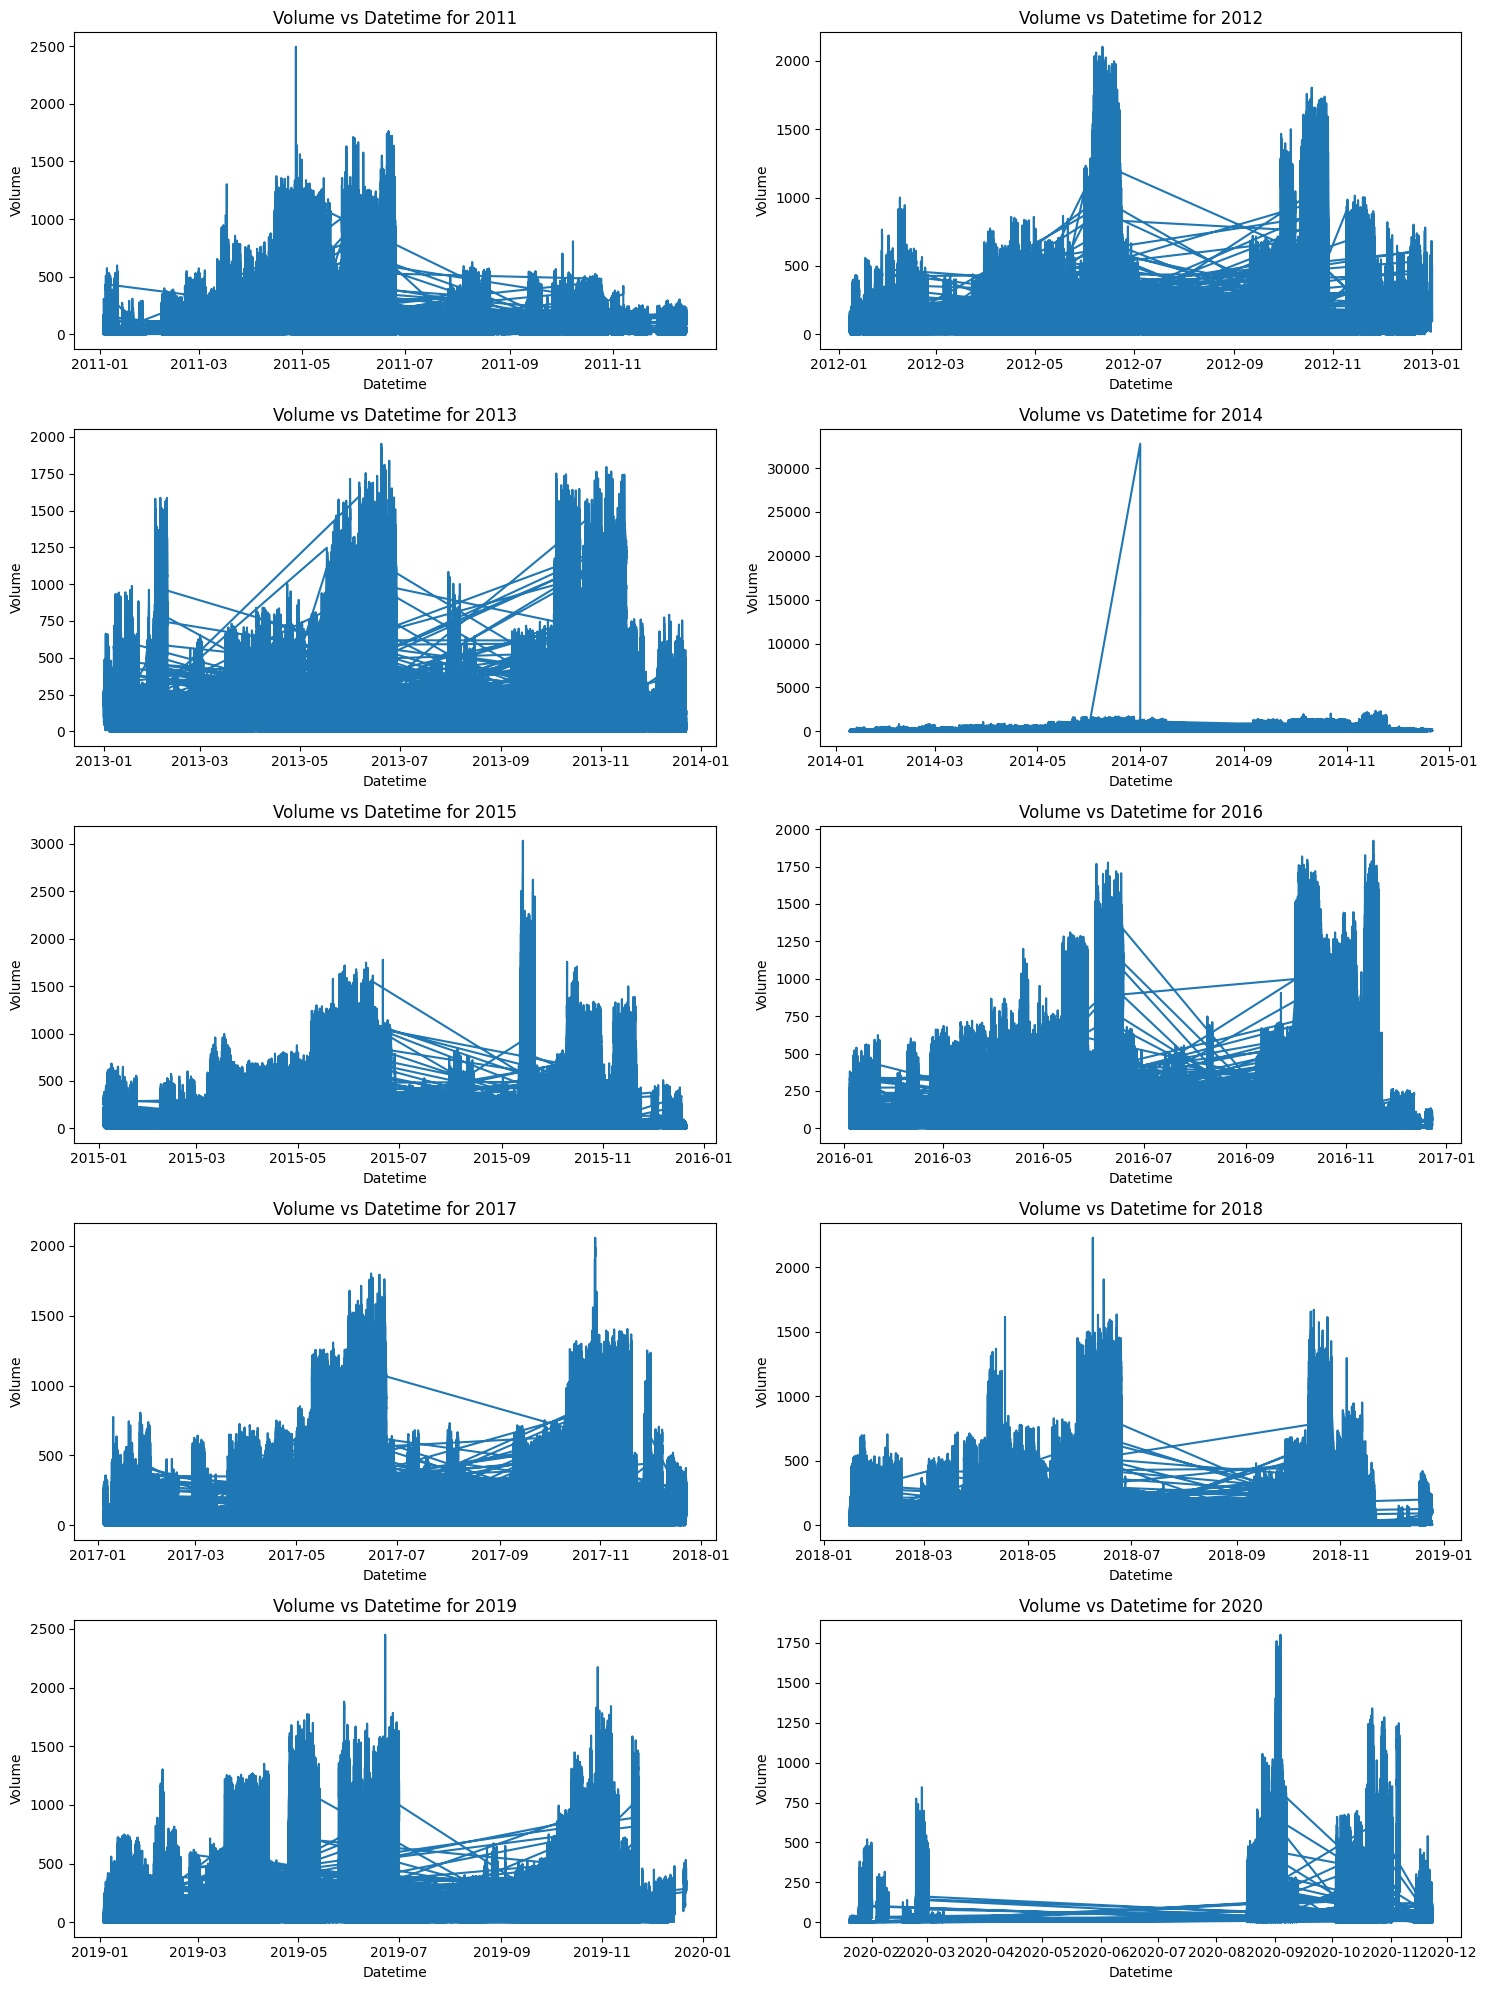

In [6]:
# Create a figure with a 5x2 grid of subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

# Loop through each year from 2011 to 2020
for i, year in enumerate(range(2011, 2021)):
    # Read the CSV file for the current year into a DataFrame
    data = pd.read_csv(f'./dataset/{year}.csv')
    
    # Preprocess the data
    data = preprocess_data(data)
    
    # Select the current axis for plotting
    ax = axes[i]
    
    # Plot 'Vol' against 'Datetime' for the current year
    ax.plot(data['Datetime'], data['Vol'])
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Volume')
    ax.set_title(f'Volume vs Datetime for {year}')
    
    # Delete the DataFrame to free up memory
    del data

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

#### Showing the number of segments in the dataset per each year

In [7]:
# Create an empty DataFrame to store the number of unique segments for each year
unique_segments_df = pd.DataFrame(columns=['Year', 'Unique Segments'])

# Loop through each year from 2011 to 2020
for year in range(2011, 2021):
    # Read the CSV file for the current year into a DataFrame
    data = pd.read_csv(f'./dataset/{year}.csv')
    
    # Preprocess the data
    data = preprocess_data(data)
    
    # Get the unique segments in the data
    unique_segments = get_unique_segments(data)
    
    # Append the year and the number of unique segments to the DataFrame
    unique_segments_df = pd.concat([unique_segments_df, pd.DataFrame({'Year': [year], 'Unique Segments': len(unique_segments)})], ignore_index=True)
    
    # Delete the DataFrame to free up memory
    del data
    gc.collect()

# Display the DataFrame with the number of unique segments for each year
display(unique_segments_df)

,Year,Unique Segments
0,2011,977
1,2012,1982
2,2013,1946
3,2014,2855
4,2015,2678
5,2016,3118
6,2017,2631
7,2018,1730
8,2019,1693
9,2020,352


#### Removing outliers of Volume (Vol) column & Finding the maximum value of Volume (Vol) column

In [42]:
# Create an empty DataFrame to store the upper limit of 'Vol' for each year
vol_upper_limits_df = pd.DataFrame(columns=['Year', 'Upper Limit'])

# Loop through each year from 2011 to 2020
for year in range(2011, 2021):
    # Read the CSV file for the current year into a DataFrame
    data = pd.read_csv(f'./dataset/{year}.csv')
    
    # Preprocess the data
    data = preprocess_data(data)
    
    # Calculate the upper limit of 'Vol' after removing outliers
    vol_upper_limit = get_vol_upper_limit(data)
    
    # Append the year and the upper limit to the DataFrame
    vol_upper_limits_df = pd.concat([vol_upper_limits_df, pd.DataFrame({'Year': [year], 'Upper Limit': vol_upper_limit})], ignore_index=True)
    
    # Delete the DataFrame to free up memory
    del data
    gc.collect()

# Display the DataFrame with the upper limit of 'Vol' for each year
display(vol_upper_limits_df)

C:\Users\Andys\AppData\Local\Temp\ipykernel_18640\911411943.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  vol_upper_limits_df = pd.concat([vol_upper_limits_df, pd.DataFrame({'Year': [year], 'Upper Limit': vol_upper_limit})], ignore_index=True)


,Year,Upper Limit
0,2011,791.0
1,2012,826.0
2,2013,854.0
3,2014,900.0
4,2015,826.0
5,2016,884.0
6,2017,760.0
7,2018,799.0
8,2019,843.0
9,2020,685.0


### Defining Functions for Feature Engineering & Model Input Preparation

#### Function to extract Volume (Vol) column from the dataset based on the above Analysis

In [8]:
# Define the lower and upper volume limits
LOWER_VOLUME_LIMIT = 0
UPPER_VOLUME_LIMIT = 1000

def extract_features(data):
    """
    Extracts and scales the 'Vol' feature from the given dataset.
    This function performs the following steps:
    1. Sorts the data by 'SegmentID', 'Direction', and 'Datetime'.
    2. Filters the data to include only rows where 'Vol' is within the specified limits.
    3. Increments the 'Vol' column by 1.
    4. Scales the 'Vol' column using MinMaxScaler with the specified feature range.
    5. Keeps only the 'Vol' column in the data.
    Parameters:
    data (pd.DataFrame): The input dataset containing traffic volume data.
    Returns:
    pd.DataFrame: A DataFrame containing the scaled 'Vol' feature.
    MinMaxScaler: The scaler used to transform the 'Vol' feature.
    """
    # Sort the data by 'SegmentID', 'Direction', and 'Datetime'
    data.sort_values(by=['SegmentID', 'Direction', 'Datetime'], inplace=True)
    
    # Filter the data to include only rows where 'Vol' is within the specified limits
    data = data[(data['Vol'] >= LOWER_VOLUME_LIMIT) & (data['Vol'] <= UPPER_VOLUME_LIMIT)].copy()
    
    # Increment the 'Vol' column by 1
    data['Vol'] = data['Vol'] + 1
    
    # Initialize the MinMaxScaler with the specified feature range
    vol_scaler = MinMaxScaler(feature_range=(LOWER_VOLUME_LIMIT, UPPER_VOLUME_LIMIT))
    
    # Scale the 'Vol' column and convert it to float
    data['Vol'] = vol_scaler.fit_transform(data[['Vol']]).astype(float)
    
    # Keep only the 'Vol' column in the data
    data = data[['Vol']]
    
    return data, vol_scaler

#### Function to create sequences of Volume (Vol) column to feed into the model

In [9]:
def create_sequences(data, time_steps):
    """
    Create sequences of a specified length from a given DataFrame.
    Parameters:
    data (pd.DataFrame): The input data as a pandas DataFrame.
    time_steps (int): The number of time steps for each sequence.
    Returns:
    np.ndarray: A NumPy array containing the created sequences, excluding the last one.
    """
    # Convert the DataFrame to a NumPy array
    data = data.values
    
    # Calculate the number of sequences that can be created
    num_sequences = len(data) - time_steps + 1
    
    # Define the strides for the as_strided function
    strides = (data.strides[0], data.strides[0] * 1) + data.strides[1:]
    
    # Create sequences using the as_strided function
    sequences = as_strided(data, shape=(num_sequences, time_steps, data.shape[1]), strides=strides)
    
    # Return all sequences except the last one
    return sequences[:-1]

#### Function to extract input sequences and corresponding target values for model training, validation, or testing.

In [10]:
def get_X_y(year, data_sequences, data, data_category, time_steps, ratio=1):
    """
    Extract input sequences and corresponding target values for model training, validation, or testing.

    Parameters:
    - year: The year of the dataset.
    - data_sequences: The sequences of data created from the dataset.
    - data: The original dataset.
    - data_category: A string indicating the category of the data (e.g., 'Train', 'Validation', 'Test').
    - time_steps: The number of time steps in each sequence.
    - ratio: The ratio of data to be used (default is 1, meaning all data).

    Returns:
    - set_X: The input sequences.
    - set_y: The corresponding target values.
    """
    set_X = None
    set_y = None
    
    if ratio == 1:
        # Use all data sequences
        set_X = data_sequences
        # Target values are the 'Vol' column values starting from the time_steps index
        set_y = data['Vol'].iloc[time_steps:].values
    else:
        # Use a subset of data sequences based on the specified ratio
        length = data_sequences.shape[0]
        random_indices = np.random.choice(length, int(ratio * length), replace=False)
        
        set_X = data_sequences[random_indices]
        set_y = data['Vol'].iloc[random_indices + time_steps].values
    
    # Print the shape of the input sequences and target values
    print(f"{data_category} set {year}: {set_X.shape[0]} sequences, each sequence of shape {set_X.shape[1:]}")
    
    return set_X, set_y

## Model Building, Model Training & Model Evaluation

### Importing Libraries

In [11]:
import os
import tensorflow as tf

# Set TensorFlow log level to suppress detailed logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# List available GPU devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Enable memory growth for each GPU to prevent TensorFlow from allocating all memory at once
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    # Print any runtime errors encountered
    print(e)

# Import necessary modules from TensorFlow and Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score
from sklearn.metrics import median_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tabulate import tabulate


2025-01-04 07:45:30.619318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735976730.760907    2680 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735976730.814143    2680 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 07:45:31.084913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Defining Functions

#### Function to define the model

In [12]:
def define_model(time_steps, feature_count):
    """
    Defines and compiles a bidirectional LSTM model for time series prediction.

    Parameters:
    time_steps (int): The number of time steps in the input data.
    feature_count (int): The number of features in the input data.

    Returns:
    keras.Model: A compiled Keras model ready for training.
    """
    # Initialize a Sequential model
    model = Sequential()
    
    # Add an input layer with the specified shape
    model.add(Input(shape=(time_steps, feature_count)))
    
    # Add a bidirectional LSTM layer with 64 units and return sequences
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    
    # Add batch normalization to normalize the activations
    model.add(BatchNormalization())
    
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))
    
    # Add another bidirectional LSTM layer with 32 units and do not return sequences
    model.add(Bidirectional(LSTM(32, return_sequences=False)))
    
    # Add batch normalization to normalize the activations
    model.add(BatchNormalization())
    
    # Add a dense layer with 16 units and ReLU activation
    model.add(Dense(16, activation='relu'))
    
    # Add a dense layer with 1 unit and ReLU activation for the output
    model.add(Dense(1, activation='relu'))
    
    # Define the learning rate for the optimizer
    learning_rate = 0.001
    
    # Initialize the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with mean squared error loss and mean absolute error metric
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # Print the model summary
    model.summary()
    
    # Return the compiled model
    return model


#### Function to train the model

In [13]:
def train_model(model, model_path, train_data, val_data, epochs, steps_per_epoch, validation_steps):
    """
    Train the model with the given datasets.

    Args:
        model (tf.keras.Model): The model to be trained.
        model_path (str): The path where the model checkpoints will be saved.
        train_data (tf.data.Dataset): The training dataset.
        val_data (tf.data.Dataset): The validation dataset.
        epochs (int): The number of epochs to train the model.
        steps_per_epoch (int): The number of steps per epoch.
        validation_steps (int): The number of validation steps.

    Returns:
        tuple: A tuple containing the trained model and the training history.
    """
    # Define a callback to save the best model based on validation loss
    checkpoint_callback = ModelCheckpoint(
        model_path,
        save_best_only=True,
        save_weights_only=False,
        monitor='val_loss',
        verbose=1
    )

    # Train the model with the training data and validate with the validation data
    history = model.fit(
        train_data,
        validation_data=val_data,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    # Return the trained model and the training history
    return model, history

#### Function to invert scaling for predicted values

In [14]:
def denormalize_volume(normalized_volume, scaler):
    """
    Denormalizes the given normalized traffic volume data using the provided scaler.

    Parameters:
    normalized_volume (array-like): The normalized traffic volume data to be denormalized.
    scaler (sklearn.preprocessing.StandardScaler or similar): The scaler object used to inverse transform the normalized data.

    Returns:
    numpy.ndarray: The denormalized traffic volume data.
    """

    # Reshape the normalized volume to a 2D array with one column
    normalized_volume = np.array(normalized_volume).reshape(-1, 1)
    
    # Use the scaler to inverse transform the normalized data to its original scale
    original_volume = scaler.inverse_transform(normalized_volume).flatten()
    
    # Return the denormalized traffic volume data
    return original_volume


#### Declaring the constants

In [15]:
# Define the number of time steps for the input sequences
TIME_STEPS = 97

# Define the number of features in the input data
FEATURE_COUNT = 1

#### Function to automate preparing the data and sequences

In [16]:
def prep_data_and_sequences(year):
    """
    Prepares data and sequences for a given year.

    This function performs the following steps:
    1. Loads the data for the specified year from a CSV file.
    2. Preprocesses the loaded data.
    3. Extracts features from the preprocessed data.
    4. Creates sequences from the extracted features.

    Args:
        year (int): The year for which the data is to be prepared.

    Returns:
        tuple: A tuple containing:
            - data (pd.DataFrame): The preprocessed data with extracted features.
            - data_sequences (list): The list of created sequences.
            - scaler (object): The scaler used for feature extraction.
    """
    print("Loading data for year", year)
    data = pd.read_csv(f'dataset/{year}.csv')
    print("Preprocessing data...")
    data = preprocess_data(data)
    print("Extracting features...")
    data, scaler = extract_features(data)
    print("Creating sequences...")
    data_sequences = create_sequences(data, TIME_STEPS)
    return data, data_sequences, scaler

#### Function to automate training and validating the model

In [17]:
def data_generator(X, y, batch_size):
    """
    Generates batches of data for training or validation.

    Parameters:
    X (np.ndarray): The input data.
    y (np.ndarray): The target values.
    batch_size (int): The number of samples per batch.

    Yields:
    tuple: A tuple containing a batch of input data and corresponding target values.
    """
    # Get the number of samples in the input data
    num_samples = X.shape[0]
    
    # Create an array of indices and shuffle them (optional)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)  # Optional: shuffle data

    # Generate batches of data
    for start in range(0, num_samples, batch_size):
        # Determine the end index of the current batch
        end = min(start + batch_size, num_samples)
        
        # Get the indices for the current batch
        batch_indices = indices[start:end]
        
        # Yield the batch of input data and corresponding target values
        yield X[batch_indices], y[batch_indices]


def train_and_validate_model(model, next_model_code, next_model_version, train_year, val_year=None, epochs=1, batch_size=32):
    """
    Trains and validates a machine learning model using time series data.
    Parameters:
    model (tf.keras.Model): The machine learning model to be trained.
    next_model_code (str): The code identifier for the next model version.
    next_model_version (str): The version identifier for the next model.
    train_year (int): The year of the training data.
    val_year (int, optional): The year of the validation data. If not provided, the year after the training year is used. Defaults to None.
    epochs (int, optional): The number of epochs to train the model. Defaults to 1.
    batch_size (int, optional): The batch size for training and validation. Defaults to 32.
    Returns:
    None
    """
    # If validation year is not provided, use the next year after the training year
    if val_year is None:
        val_year = train_year + 1

    print("----------------------------------------\n")
    
    # Prepare training data and sequences for the specified training year
    train_data, train_data_sequences, train_scaler = prep_data_and_sequences(train_year)
    
    # Prepare validation data and sequences for the specified validation year
    val_data, val_data_sequences, val_scaler = prep_data_and_sequences(val_year)

    # Extract input sequences and target values for training
    train_X, train_y = get_X_y(train_year, train_data_sequences, train_data, 'Train', TIME_STEPS)
    
    # Extract input sequences and target values for validation with a ratio of 0.25
    val_X, val_y = get_X_y(val_year, val_data_sequences, val_data, 'Validation', TIME_STEPS, ratio=0.25)

    # Calculate the number of steps per epoch for training and validation
    steps_per_epoch = int(np.floor(train_X.shape[0] / batch_size))
    validation_steps = int(np.floor(val_X.shape[0] / batch_size))
    
    # Adjust the number of samples to be a multiple of the batch size
    new_train_num_samples = steps_per_epoch * batch_size
    new_val_num_samples = validation_steps * batch_size
    
    # Trim the training and validation data to match the new number of samples
    train_X = train_X[:new_train_num_samples]
    train_y = train_y[:new_train_num_samples]
    val_X = val_X[:new_val_num_samples]
    val_y = val_y[:new_val_num_samples]
    
    # Create a TensorFlow dataset for training
    train_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(train_X, train_y, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(batch_size, TIME_STEPS, FEATURE_COUNT), dtype=tf.float32),
            tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)
        )
    ).repeat().prefetch(tf.data.AUTOTUNE)

    # Create a TensorFlow dataset for validation
    val_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(val_X, val_y, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(batch_size, TIME_STEPS, FEATURE_COUNT), dtype=tf.float32),
            tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)
        )
    ).repeat().prefetch(tf.data.AUTOTUNE)

    print("Training model...")
    
    # Train the model using the training and validation datasets
    model, history = train_model(
        model, 
        f"models/{next_model_code}-{next_model_version}.keras", 
        train_dataset, 
        val_dataset,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch, 
        validation_steps=validation_steps
    )

    print("Model trained successfully for year", train_year)

    # Clean up and free memory
    del train_data, train_data_sequences, train_scaler, val_data, val_data_sequences, val_scaler, train_X, train_y, val_X, val_y
    gc.collect()

#### Function to automate testing the model

In [18]:
def test_data_generator(X, y, batch_size):
    """
    A generator function that yields batches of data from the given datasets.

    Args:
        X (numpy.ndarray): The input data array.
        y (numpy.ndarray): The target data array.
        batch_size (int): The number of samples per batch.

    Yields:
        tuple: A tuple containing a batch of input data (X) and the corresponding target data (y).
    """
    num_samples = X.shape[0]
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        yield X[start:end], y[start:end]

def evaluate_model(model, year, batch_size=1024):
    """
    Evaluate the performance of a given model on test data for a specific year.
    Parameters:
    model (tf.keras.Model): The trained model to evaluate.
    year (int): The year of the test data to evaluate the model on.
    batch_size (int, optional): The size of the batches for testing. Default is 1024.
    Returns:
    None
    This function performs the following steps:
    1. Prepares the test data and sequences for the specified year.
    2. Calculates the number of steps (batches) based on the batch size.
    3. Creates a TensorFlow Dataset from the test data generator.
    4. Generates predictions using the model.
    5. Denormalizes the predictions and actual values.
    6. Calculates evaluation metrics (MAE, MAPE, RMSE, MedAE, R2 Score).
    7. Compiles the metrics into a DataFrame and displays the results.
    8. Plots the actual vs predicted traffic volumes.
    Note:
    - The function assumes the existence of helper functions: `prep_data_and_sequences`, `get_X_y`, 
      `test_data_generator`, `denormalize_volume`, `mean_absolute_error`, `mean_absolute_percentage_error`, 
      `root_mean_squared_error`, `median_absolute_error`, and `r2_score`.
    - The function also assumes the presence of constants: `TIME_STEPS` and `FEATURE_COUNT`.
    """
    # Prepare the test data and sequences for the specified year
    data, data_sequences, scaler = prep_data_and_sequences(year)
    
    # Extract input sequences and target values for testing
    test_X, test_y = get_X_y(year, data_sequences, data, 'Test', TIME_STEPS)

    # Calculate the number of steps (batches) based on the batch size
    num_samples = test_X.shape[0]
    steps = int(np.floor(num_samples / batch_size))
    
    # Adjust the number of samples to be a multiple of the batch size
    new_num_samples = steps * batch_size
    test_X = test_X[:new_num_samples]
    test_y = test_y[:new_num_samples]

    # Create a TensorFlow dataset for testing
    test_dataset = tf.data.Dataset.from_generator(
        lambda: test_data_generator(test_X, test_y, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(None, TIME_STEPS, FEATURE_COUNT), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    ).prefetch(tf.data.AUTOTUNE)

    # Generate predictions using the model
    test_predictions = model.predict(test_dataset, steps=steps)
    test_predictions = np.round(test_predictions)

    # Denormalize the predictions and actual values
    test_predictions_denorm = np.array([denormalize_volume(pred, scaler) for pred in test_predictions[:, 0]])
    test_y_denorm = np.array([denormalize_volume(vol, scaler) for vol in test_y])

    # Calculate evaluation metrics
    mae = mean_absolute_error(test_y_denorm, test_predictions_denorm)
    mape = mean_absolute_percentage_error(test_y_denorm, test_predictions_denorm)
    rmse = root_mean_squared_error(test_y_denorm, test_predictions_denorm)
    medae = median_absolute_error(test_y_denorm, test_predictions_denorm)
    r2 = r2_score(test_y_denorm, test_predictions_denorm)

    # Compile the metrics into a DataFrame and display the results
    metrics = {
        'Year': [year],
        'Mean Absolute Error': [mae],
        'Mean Absolute Percentage Error': [mape],
        'Root Mean Squared Error': [rmse],
        'Median Absolute Error': [medae],
        'R2 Score': [r2],
    }
    results_df = pd.DataFrame(metrics)
    print(tabulate(results_df, headers="keys", tablefmt="pretty", showindex=False))

    # Plot the actual vs predicted traffic volumes
    plt.figure(figsize=(12, 6))
    plt.plot(test_y_denorm, label='Actual Volumes', color='blue', alpha=0.7, linewidth=2)
    plt.plot(test_predictions_denorm, label='Predicted Volumes', color='red', linestyle='--', alpha=0.7, linewidth=2)
    plt.title('Actual vs Predicted Traffic Volumes', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Traffic Volume', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()


### Process Starts Here

#### Training on dataset 2011-2016 with batch size 32 (default) each for 1 epoch

In [26]:
model = define_model(TIME_STEPS, FEATURE_COUNT)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 97, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 97, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 97, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,833 (300.13 KB)

 Trainable params: 76,449 (298.63 KB)

 Non-trainable params: 384 (1.50 KB)

In [27]:
train_and_validate_model(model=model, next_model_code='t', next_model_version=1, train_year=2011)

----------------------------------------

Loading data for year 2011
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2012
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2011: 1156450 sequences, each sequence of shape (97, 1)
Validation set 2012: 588155 sequences, each sequence of shape (97, 1)
Training model...
36140/36140 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 2517.4038 - mae: 24.9225
Epoch 1: val_loss improved from inf to 1533.22791, saving model to models/t-1.keras
36140/36140 ━━━━━━━━━━━━━━━━━━━━ 3421s 94ms/step - loss: 2517.3818 - mae: 24.9224 - val_loss: 1533.2279 - val_mae: 24.0732
Model trained successfully for year 2020


In [12]:
model = load_model('models/t-1.keras'); train_and_validate_model(model=model, next_model_code='t', next_model_version=2, train_year=2012)

----------------------------------------

Loading data for year 2012
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2013
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2012: 2352623 sequences, each sequence of shape (97, 1)
Validation set 2013: 677547 sequences, each sequence of shape (97, 1)
Training model...
73520/73520 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 1155.5206 - mae: 18.3291
Epoch 1: val_loss improved from inf to 879.19867, saving model to models/t-2.keras
73520/73520 ━━━━━━━━━━━━━━━━━━━━ 6778s 92ms/step - loss: 1155.5203 - mae: 18.3291 - val_loss: 879.1987 - val_mae: 14.0863
Model trained successfully for year 2012


In [13]:
model = load_model('models/t-2.keras'); train_and_validate_model(model=model, next_model_code='t', next_model_version=3, train_year=2013)

----------------------------------------

Loading data for year 2013
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2014
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2013: 2710191 sequences, each sequence of shape (97, 1)
Validation set 2014: 890573 sequences, each sequence of shape (97, 1)
Training model...
84694/84694 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1023.1167 - mae: 16.3311
Epoch 1: val_loss improved from inf to 682.21906, saving model to models/t-3.keras
84694/84694 ━━━━━━━━━━━━━━━━━━━━ 7436s 88ms/step - loss: 1023.1163 - mae: 16.3311 - val_loss: 682.2191 - val_mae: 13.4512
Model trained successfully for year 2013


In [14]:
model = load_model('models/t-3.keras'); train_and_validate_model(model=model, next_model_code='t', next_model_version=4, train_year=2014)

----------------------------------------

Loading data for year 2014
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2015
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2014: 3562292 sequences, each sequence of shape (97, 1)
Validation set 2015: 780024 sequences, each sequence of shape (97, 1)
Training model...
111322/111322 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 886.8726 - mae: 16.1879
Epoch 1: val_loss improved from inf to 758.76843, saving model to models/t-4.keras
111322/111322 ━━━━━━━━━━━━━━━━━━━━ 10590s 95ms/step - loss: 886.8724 - mae: 16.1879 - val_loss: 758.7684 - val_mae: 18.2598
Model trained successfully for year 2014


In [12]:
model = load_model('models/t-4.keras'); train_and_validate_model(model=model, next_model_code='t', next_model_version=5, train_year=2015)

----------------------------------------

Loading data for year 2015
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2016
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2015: 3120096 sequences, each sequence of shape (97, 1)
Validation set 2016: 817347 sequences, each sequence of shape (97, 1)
Training model...
97503/97503 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 716.1016 - mae: 15.1034
Epoch 1: val_loss improved from inf to 607.09418, saving model to models/t-5.keras
97503/97503 ━━━━━━━━━━━━━━━━━━━━ 6713s 69ms/step - loss: 716.1015 - mae: 15.1034 - val_loss: 607.0942 - val_mae: 13.8687
Model trained successfully for year 2015


In [13]:
model = load_model('models/t-5.keras'); train_and_validate_model(model=model, next_model_code='t', next_model_version=6, train_year=2016)

----------------------------------------

Loading data for year 2016
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2017
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2016: 3269389 sequences, each sequence of shape (97, 1)
Validation set 2017: 721310 sequences, each sequence of shape (97, 1)
Training model...
102169/102169 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 745.7833 - mae: 15.0870
Epoch 1: val_loss improved from inf to 674.14923, saving model to models/t-6.keras
102169/102169 ━━━━━━━━━━━━━━━━━━━━ 7925s 78ms/step - loss: 745.7831 - mae: 15.0870 - val_loss: 674.1492 - val_mae: 14.0024
Model trained successfully for year 2016


#### Testing on dataset 2017-2020 with model t-6

Loading data for year 2017
Preprocessing data...
Extracting features...
Creating sequences...
Test set 2017: 2885242 sequences, each sequence of shape (97, 1)
2817/2817 ━━━━━━━━━━━━━━━━━━━━ 116s 40ms/step
+--------+---------------------+--------------------------------+-------------------------+-----------------------+-------------------+
|  Year  | Mean Absolute Error | Mean Absolute Percentage Error | Root Mean Squared Error | Median Absolute Error |     R2 Score      |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+-------------------+
| 2017.0 | 14.016069081136848  |       0.7520362675807755       |   25.921241665956188    |          9.0          | 0.957431497331363 |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+-------------------+


/home/andystmc/working/wsl-python/wslpy-tensorflow/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


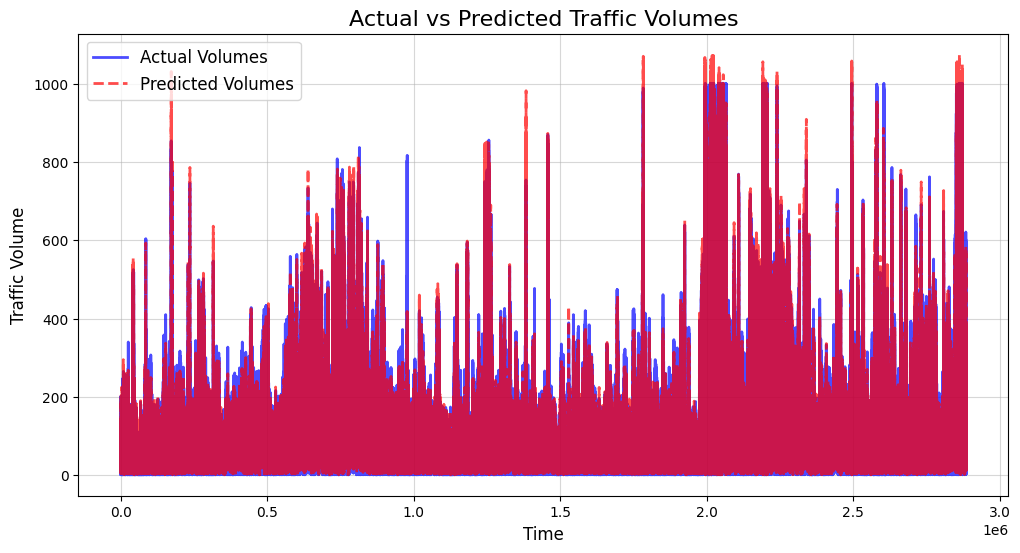

In [34]:
model = load_model('models/t-6.keras'); evaluate_model(model, 2017)

Loading data for year 2018
Preprocessing data...
Extracting features...
Creating sequences...
Test set 2018: 1989158 sequences, each sequence of shape (97, 1)
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
|  Year  | Mean Absolute Error | Mean Absolute Percentage Error | Root Mean Squared Error | Median Absolute Error |      R2 Score      |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
| 2018.0 | 14.072832855947476  |       1.0243911445012606       |    26.78380308179664    |          8.0          | 0.9550242670581471 |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+


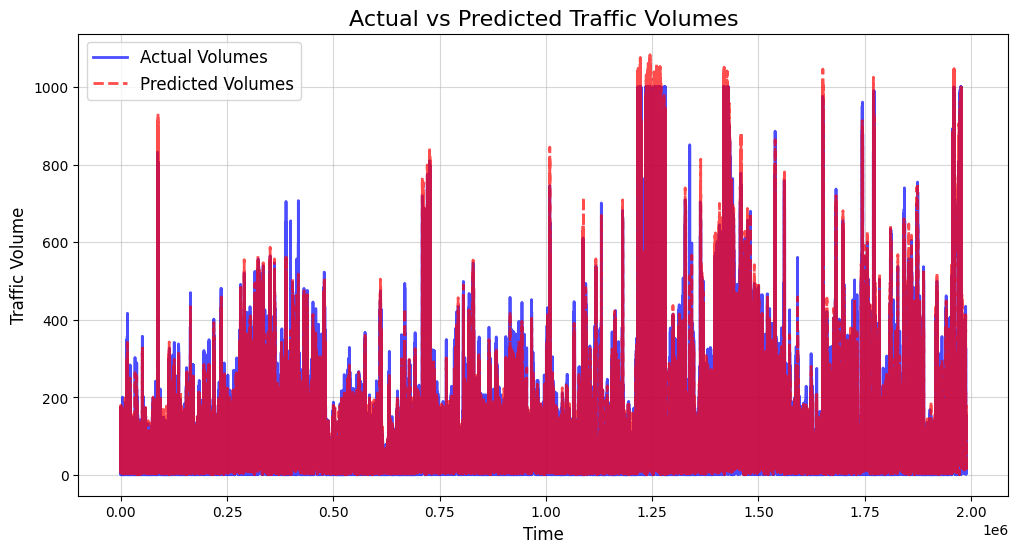

In [35]:
model = load_model('models/t-6.keras'); evaluate_model(model, 2018)

Loading data for year 2019
Preprocessing data...
Extracting features...
Creating sequences...
Test set 2019: 2317291 sequences, each sequence of shape (97, 1)
2262/2262 ━━━━━━━━━━━━━━━━━━━━ 91s 40ms/step
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
|  Year  | Mean Absolute Error | Mean Absolute Percentage Error | Root Mean Squared Error | Median Absolute Error |      R2 Score      |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
| 2019.0 | 13.893189016219054  |       0.7091867314564404       |    24.47630466731091    |          9.0          | 0.9620666563392252 |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+


/home/andystmc/working/wsl-python/wslpy-tensorflow/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


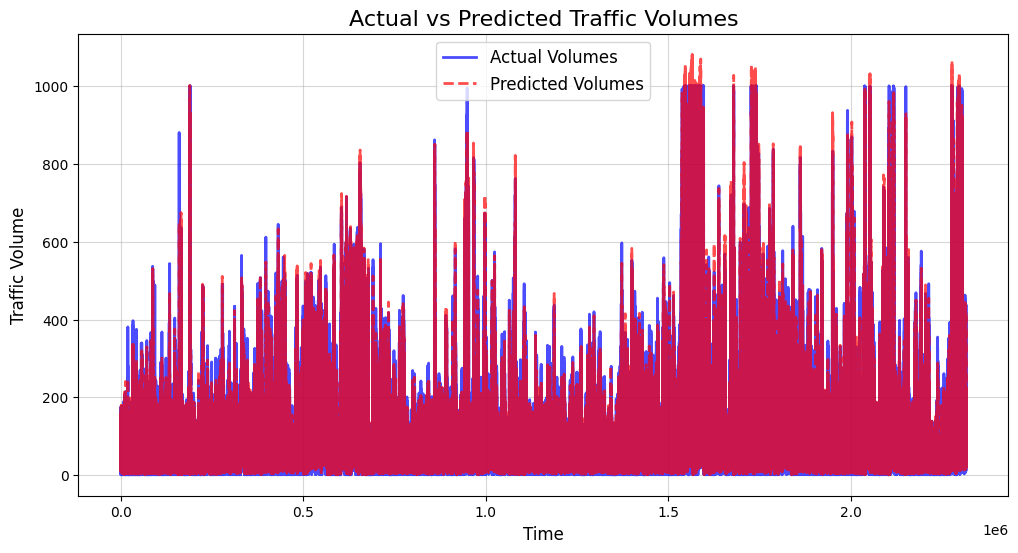

In [36]:
model = load_model('models/t-6.keras'); evaluate_model(model, 2019)

I0000 00:00:1735901047.885553    6702 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Loading data for year 2020
Preprocessing data...
Extracting features...
Creating sequences...
Test set 2020: 436014 sequences, each sequence of shape (97, 1)


I0000 00:00:1735901055.504729    6796 cuda_dnn.cc:529] Loaded cuDNN version 90300


425/425 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
|  Year  | Mean Absolute Error | Mean Absolute Percentage Error | Root Mean Squared Error | Median Absolute Error |      R2 Score      |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
| 2020.0 | 13.026957720588236  |       0.5251690751719282       |   23.257516771939752    |          8.0          | 0.9656607087145984 |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+


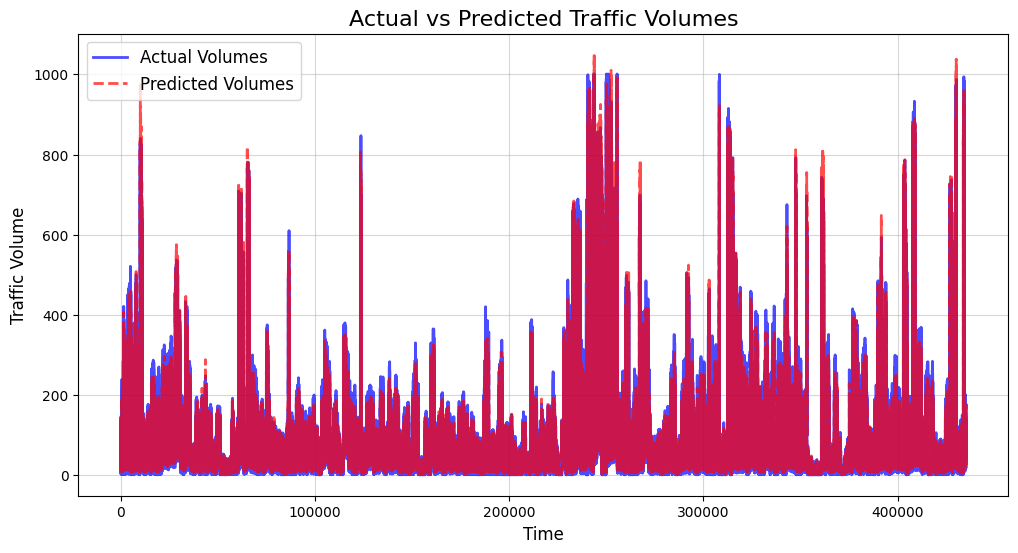

In [19]:
model = load_model('models/t-6.keras'); evaluate_model(model, 2020)

#### Training on dataset 2011-2016 with batch size 256 (increment from 32) each for 1 epoch

In [28]:
model = load_model('models/t-6.keras'); train_and_validate_model(model=model, next_model_code='u', next_model_version=7, train_year=2011, epochs=2, batch_size=256)

----------------------------------------

Loading data for year 2011
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2012
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2011: 1156450 sequences, each sequence of shape (97, 1)
Validation set 2012: 588155 sequences, each sequence of shape (97, 1)
Training model...
Epoch 1/2
4517/4517 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 975.6124 - mae: 14.1938
Epoch 1: val_loss improved from inf to 739.82104, saving model to models/u-7.keras
4517/4517 ━━━━━━━━━━━━━━━━━━━━ 327s 72ms/step - loss: 975.6068 - mae: 14.1938 - val_loss: 739.8210 - val_mae: 13.6147
Epoch 2/2
4517/4517 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 945.1512 - mae: 14.1304
Epoch 2: val_loss improved from 739.82104 to 661.02612, saving model to models/u-7.keras
4517/4517 ━━━━━━━━━━━━━━━━━━━━ 297s 66ms/step - loss: 945.1483 - mae: 14.1304 - val_loss: 661.0261 - val_mae: 12.8882
Model trained successfully for year 

In [29]:
model = load_model('models/u-7.keras'); train_and_validate_model(model=model, next_model_code='u', next_model_version=8, train_year=2012, epochs=2, batch_size=256)

----------------------------------------

Loading data for year 2012
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2013
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2012: 2352623 sequences, each sequence of shape (97, 1)
Validation set 2013: 677547 sequences, each sequence of shape (97, 1)
Training model...
Epoch 1/2
9189/9189 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 680.6545 - mae: 12.9740
Epoch 1: val_loss improved from inf to 660.88354, saving model to models/u-8.keras
9189/9189 ━━━━━━━━━━━━━━━━━━━━ 579s 63ms/step - loss: 680.6539 - mae: 12.9740 - val_loss: 660.8835 - val_mae: 12.7692
Epoch 2/2
9189/9189 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 664.9205 - mae: 12.8772
Epoch 2: val_loss did not improve from 660.88354
9189/9189 ━━━━━━━━━━━━━━━━━━━━ 585s 64ms/step - loss: 664.9201 - mae: 12.8772 - val_loss: 1098.9471 - val_mae: 14.8091
Model trained successfully for year 2012


In [30]:
model = load_model('models/u-8.keras'); train_and_validate_model(model=model, next_model_code='u', next_model_version=9, train_year=2013, epochs=2, batch_size=256)

----------------------------------------

Loading data for year 2013
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2014
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2013: 2710191 sequences, each sequence of shape (97, 1)
Validation set 2014: 890573 sequences, each sequence of shape (97, 1)
Training model...
Epoch 1/2
10586/10586 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 665.8541 - mae: 12.3183
Epoch 1: val_loss improved from inf to 615.92786, saving model to models/u-9.keras
10586/10586 ━━━━━━━━━━━━━━━━━━━━ 713s 67ms/step - loss: 665.8539 - mae: 12.3183 - val_loss: 615.9279 - val_mae: 13.7831
Epoch 2/2
10586/10586 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 653.2114 - mae: 12.1822
Epoch 2: val_loss did not improve from 615.92786
10586/10586 ━━━━━━━━━━━━━━━━━━━━ 726s 69ms/step - loss: 653.2114 - mae: 12.1822 - val_loss: 639.3470 - val_mae: 13.8151
Model trained successfully for year 2013


In [31]:
model = load_model('models/u-9.keras'); train_and_validate_model(model=model, next_model_code='u', next_model_version=10, train_year=2014, epochs=2, batch_size=256)

----------------------------------------

Loading data for year 2014
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2015
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2014: 3562292 sequences, each sequence of shape (97, 1)
Validation set 2015: 780024 sequences, each sequence of shape (97, 1)
Training model...
Epoch 1/2
13915/13915 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 575.4609 - mae: 12.4827
Epoch 1: val_loss improved from inf to 804.82001, saving model to models/u-10.keras
13915/13915 ━━━━━━━━━━━━━━━━━━━━ 1102s 79ms/step - loss: 575.4606 - mae: 12.4827 - val_loss: 804.8200 - val_mae: 14.1371
Epoch 2/2
13915/13915 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 570.0277 - mae: 12.3965
Epoch 2: val_loss improved from 804.82001 to 742.88495, saving model to models/u-10.keras
13915/13915 ━━━━━━━━━━━━━━━━━━━━ 1304s 94ms/step - loss: 570.0272 - mae: 12.3965 - val_loss: 742.8849 - val_mae: 14.3320
Model trained successful

In [32]:
model = load_model('models/u-10.keras'); train_and_validate_model(model=model, next_model_code='u', next_model_version=11, train_year=2015, epochs=2, batch_size=256)

----------------------------------------

Loading data for year 2015
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2016
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2015: 3120096 sequences, each sequence of shape (97, 1)
Validation set 2016: 817347 sequences, each sequence of shape (97, 1)
Training model...
Epoch 1/2
12187/12187 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 525.1329 - mae: 12.6606
Epoch 1: val_loss improved from inf to 1068.30701, saving model to models/u-11.keras
12187/12187 ━━━━━━━━━━━━━━━━━━━━ 1218s 99ms/step - loss: 525.1326 - mae: 12.6606 - val_loss: 1068.3070 - val_mae: 15.5566
Epoch 2/2
12187/12187 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 514.9174 - mae: 12.5320
Epoch 2: val_loss improved from 1068.30701 to 977.07043, saving model to models/u-11.keras
12187/12187 ━━━━━━━━━━━━━━━━━━━━ 1350s 111ms/step - loss: 514.9174 - mae: 12.5320 - val_loss: 977.0704 - val_mae: 14.7971
Model trained succe

In [33]:
model = load_model('models/u-11.keras'); train_and_validate_model(model=model, next_model_code='u', next_model_version=12, train_year=2016, epochs=2, batch_size=256)

----------------------------------------

Loading data for year 2016
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2017
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2016: 3269389 sequences, each sequence of shape (97, 1)
Validation set 2017: 721310 sequences, each sequence of shape (97, 1)
Training model...
Epoch 1/2
12771/12771 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 543.7511 - mae: 12.5854
Epoch 1: val_loss improved from inf to 557.39044, saving model to models/u-12.keras
12771/12771 ━━━━━━━━━━━━━━━━━━━━ 1549s 120ms/step - loss: 543.7510 - mae: 12.5854 - val_loss: 557.3904 - val_mae: 12.5574
Epoch 2/2
12771/12771 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 536.4982 - mae: 12.5327
Epoch 2: val_loss improved from 557.39044 to 549.79126, saving model to models/u-12.keras
12771/12771 ━━━━━━━━━━━━━━━━━━━━ 1272s 100ms/step - loss: 536.4984 - mae: 12.5327 - val_loss: 549.7913 - val_mae: 12.6993
Model trained success

#### Testing on dataset 2017-2020 with model u-12

I0000 00:00:1735971363.827128     717 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Loading data for year 2017
Preprocessing data...
Extracting features...
Creating sequences...
Test set 2017: 2885242 sequences, each sequence of shape (97, 1)


I0000 00:00:1735971394.417608     807 cuda_dnn.cc:529] Loaded cuDNN version 90300


2817/2817 ━━━━━━━━━━━━━━━━━━━━ 108s 38ms/step
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
|  Year  | Mean Absolute Error | Mean Absolute Percentage Error | Root Mean Squared Error | Median Absolute Error |      R2 Score      |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
| 2017.0 | 12.677748935037274  |      0.40752247045852946       |   23.388345479126485    |          7.0          | 0.9653442124244423 |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+


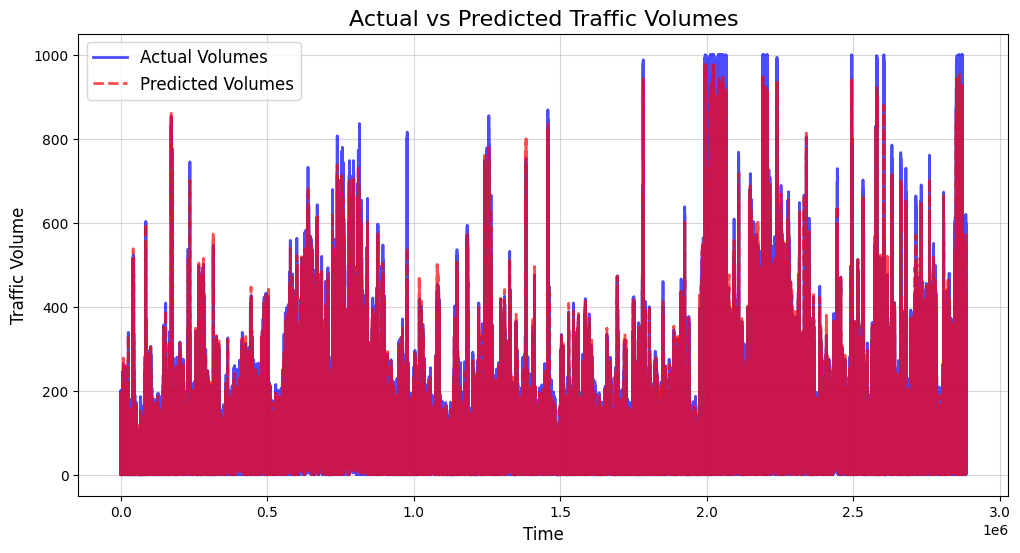

In [19]:
model = load_model('models/u-12.keras'); evaluate_model(model, 2017)

Loading data for year 2018
Preprocessing data...
Extracting features...
Creating sequences...
Test set 2018: 1989158 sequences, each sequence of shape (97, 1)
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 71s 36ms/step
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
|  Year  | Mean Absolute Error | Mean Absolute Percentage Error | Root Mean Squared Error | Median Absolute Error |      R2 Score      |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
| 2018.0 | 12.670287457357107  |       0.5657085912138542       |    24.57124596856329    |          7.0          | 0.9621480618594964 |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+


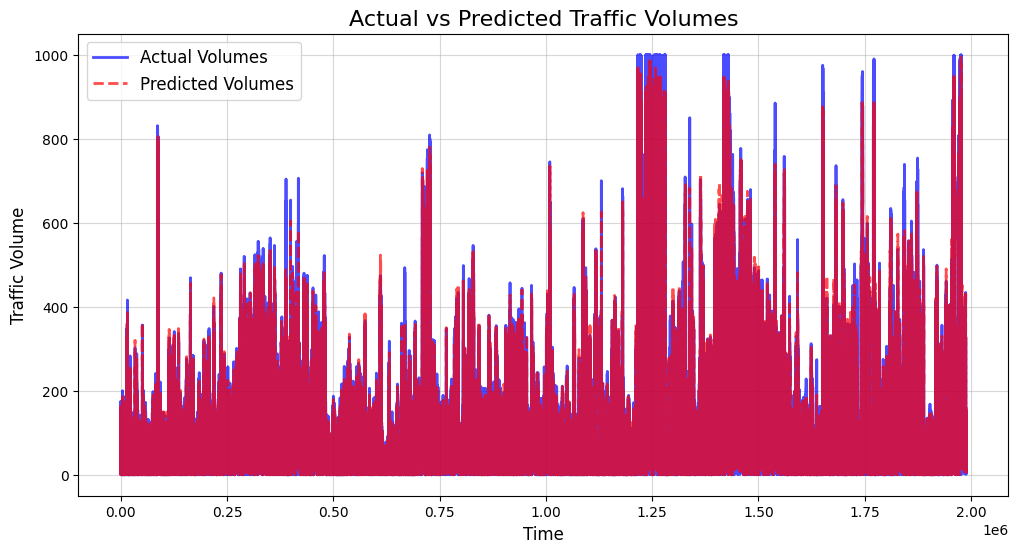

In [20]:
model = load_model('models/u-12.keras'); evaluate_model(model, 2018)

Loading data for year 2019
Preprocessing data...
Extracting features...
Creating sequences...
Test set 2019: 2317291 sequences, each sequence of shape (97, 1)
2262/2262 ━━━━━━━━━━━━━━━━━━━━ 83s 37ms/step
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
|  Year  | Mean Absolute Error | Mean Absolute Percentage Error | Root Mean Squared Error | Median Absolute Error |      R2 Score      |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
| 2019.0 |  12.72117629586649  |      0.36675653271415354       |   22.263474866905092    |          8.0          | 0.9686154920542079 |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+


/home/andystmc/working/wsl-python/wslpy-tensorflow/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


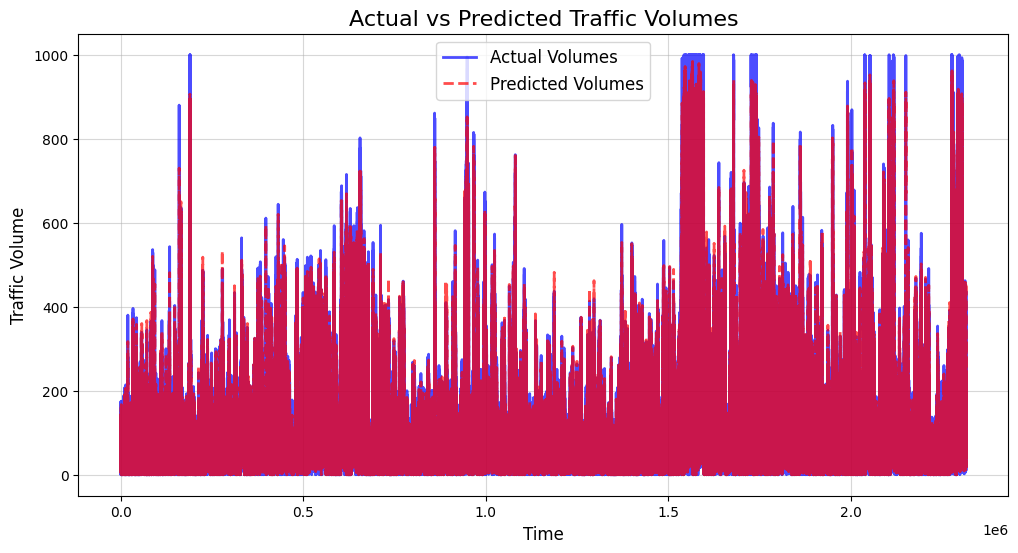

In [21]:
model = load_model('models/u-12.keras'); evaluate_model(model, 2019)

Loading data for year 2020
Preprocessing data...
Extracting features...
Creating sequences...
Test set 2020: 436014 sequences, each sequence of shape (97, 1)
425/425 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
|  Year  | Mean Absolute Error | Mean Absolute Percentage Error | Root Mean Squared Error | Median Absolute Error |      R2 Score      |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
| 2020.0 | 11.748157169117647  |      0.34018392904545675       |   20.400350973768592    |          7.0          | 0.9735795676333926 |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+


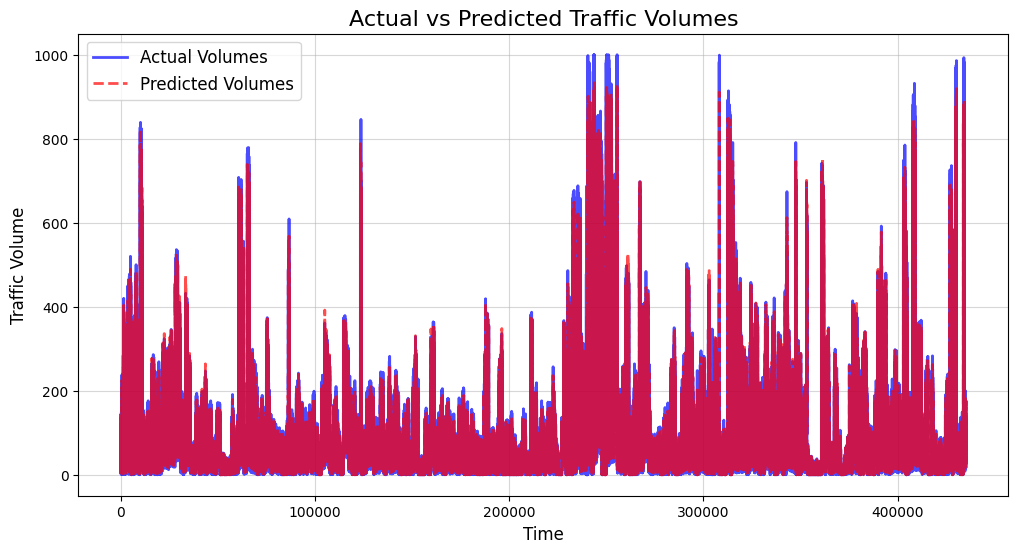

In [22]:
model = load_model('models/u-12.keras'); evaluate_model(model, 2020)

#### Training on dataset 2011-2016 with batch size 1024 (increment from 256) each for 1 epoch

In [19]:
model = load_model('models/u-12.keras'); train_and_validate_model(model=model, next_model_code='v', next_model_version=13, train_year=2011, epochs=3, batch_size=1024)

I0000 00:00:1735976742.894261    2680 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


----------------------------------------

Loading data for year 2011
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2012
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2011: 1156450 sequences, each sequence of shape (97, 1)
Validation set 2012: 588155 sequences, each sequence of shape (97, 1)
Training model...
Epoch 1/3


I0000 00:00:1735976771.856602    2809 cuda_dnn.cc:529] Loaded cuDNN version 90300


1129/1129 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 846.7159 - mae: 13.1092
Epoch 1: val_loss improved from inf to 725.14001, saving model to models/v-13.keras
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 130s 110ms/step - loss: 846.7271 - mae: 13.1092 - val_loss: 725.1400 - val_mae: 13.4233
Epoch 2/3
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 849.5702 - mae: 13.1019
Epoch 2: val_loss did not improve from 725.14001
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 127s 112ms/step - loss: 849.5717 - mae: 13.1019 - val_loss: 836.4176 - val_mae: 13.8973
Epoch 3/3
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 856.5042 - mae: 13.1152
Epoch 3: val_loss improved from 725.14001 to 684.06500, saving model to models/v-13.keras
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 130s 115ms/step - loss: 856.4995 - mae: 13.1152 - val_loss: 684.0650 - val_mae: 13.0290
Model trained successfully for year 2011


In [20]:
model = load_model('models/v-13.keras'); train_and_validate_model(model=model, next_model_code='v', next_model_version=14, train_year=2012, epochs=3, batch_size=1024)

----------------------------------------

Loading data for year 2012
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2013
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2012: 2352623 sequences, each sequence of shape (97, 1)
Validation set 2013: 677547 sequences, each sequence of shape (97, 1)
Training model...
Epoch 1/3
2297/2297 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 610.3676 - mae: 12.1053
Epoch 1: val_loss improved from inf to 670.75989, saving model to models/v-14.keras
2297/2297 ━━━━━━━━━━━━━━━━━━━━ 250s 107ms/step - loss: 610.3666 - mae: 12.1053 - val_loss: 670.7599 - val_mae: 12.3898
Epoch 2/3
2297/2297 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 600.2051 - mae: 12.0822
Epoch 2: val_loss improved from 670.75989 to 661.61292, saving model to models/v-14.keras
2297/2297 ━━━━━━━━━━━━━━━━━━━━ 249s 108ms/step - loss: 600.2068 - mae: 12.0822 - val_loss: 661.6129 - val_mae: 12.1534
Epoch 3/3
2297/2297 ━━━━━━━━━━━━

In [21]:
model = load_model('models/v-14.keras'); train_and_validate_model(model=model, next_model_code='v', next_model_version=15, train_year=2013, epochs=3, batch_size=1024)

----------------------------------------

Loading data for year 2013
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2014
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2013: 2710191 sequences, each sequence of shape (97, 1)
Validation set 2014: 890573 sequences, each sequence of shape (97, 1)
Training model...
Epoch 1/3
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 603.8629 - mae: 11.5653
Epoch 1: val_loss improved from inf to 772.67969, saving model to models/v-15.keras
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 293s 109ms/step - loss: 603.8635 - mae: 11.5653 - val_loss: 772.6797 - val_mae: 13.4695
Epoch 2/3
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 598.2397 - mae: 11.5211
Epoch 2: val_loss improved from 772.67969 to 557.40210, saving model to models/v-15.keras
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 292s 110ms/step - loss: 598.2406 - mae: 11.5211 - val_loss: 557.4021 - val_mae: 12.2950
Epoch 3/3
2646/2646 ━━━━━━━━━━━━

In [22]:
model = load_model('models/v-15.keras'); train_and_validate_model(model=model, next_model_code='v', next_model_version=16, train_year=2014, epochs=3, batch_size=1024)

----------------------------------------

Loading data for year 2014
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2015
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2014: 3562292 sequences, each sequence of shape (97, 1)
Validation set 2015: 780024 sequences, each sequence of shape (97, 1)
Training model...
Epoch 1/3
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 527.2097 - mae: 11.8238
Epoch 1: val_loss improved from inf to 565.61102, saving model to models/v-16.keras
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 368s 104ms/step - loss: 527.2089 - mae: 11.8238 - val_loss: 565.6110 - val_mae: 13.6497
Epoch 2/3
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 518.7576 - mae: 11.7823
Epoch 2: val_loss improved from 565.61102 to 520.68744, saving model to models/v-16.keras
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 359s 103ms/step - loss: 518.7578 - mae: 11.7823 - val_loss: 520.6874 - val_mae: 12.7496
Epoch 3/3
3478/3478 ━━━━━━━━━━━━

In [23]:
model = load_model('models/v-16.keras'); train_and_validate_model(model=model, next_model_code='v', next_model_version=17, train_year=2015, epochs=3, batch_size=1024)

----------------------------------------

Loading data for year 2015
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2016
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2015: 3120096 sequences, each sequence of shape (97, 1)
Validation set 2016: 817347 sequences, each sequence of shape (97, 1)
Training model...
Epoch 1/3
3046/3046 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 486.9083 - mae: 12.1251
Epoch 1: val_loss improved from inf to 544.02167, saving model to models/v-17.keras
3046/3046 ━━━━━━━━━━━━━━━━━━━━ 331s 107ms/step - loss: 486.9076 - mae: 12.1251 - val_loss: 544.0217 - val_mae: 12.6970
Epoch 2/3
3046/3046 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 483.6991 - mae: 12.0871
Epoch 2: val_loss did not improve from 544.02167
3046/3046 ━━━━━━━━━━━━━━━━━━━━ 325s 107ms/step - loss: 483.6985 - mae: 12.0871 - val_loss: 946.0234 - val_mae: 15.3109
Epoch 3/3
3046/3046 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 485.0788 - 

In [24]:
model = load_model('models/v-17.keras'); train_and_validate_model(model=model, next_model_code='v', next_model_version=18, train_year=2016, epochs=3, batch_size=1024)

----------------------------------------

Loading data for year 2016
Preprocessing data...
Extracting features...
Creating sequences...
Loading data for year 2017
Preprocessing data...
Extracting features...
Creating sequences...
Train set 2016: 3269389 sequences, each sequence of shape (97, 1)
Validation set 2017: 721310 sequences, each sequence of shape (97, 1)
Training model...
Epoch 1/3
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 510.4135 - mae: 12.1330
Epoch 1: val_loss improved from inf to 536.39514, saving model to models/v-18.keras
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 337s 104ms/step - loss: 510.4120 - mae: 12.1330 - val_loss: 536.3951 - val_mae: 12.2385
Epoch 2/3
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 505.6142 - mae: 12.0996
Epoch 2: val_loss did not improve from 536.39514
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 341s 107ms/step - loss: 505.6134 - mae: 12.0996 - val_loss: 618.5569 - val_mae: 12.9164
Epoch 3/3
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 499.7921 - 

#### Testing on dataset 2017-2020 with model v-18

Loading data for year 2017
Preprocessing data...
Extracting features...
Creating sequences...
Test set 2017: 2885242 sequences, each sequence of shape (97, 1)
2817/2817 ━━━━━━━━━━━━━━━━━━━━ 100s 35ms/step
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
|  Year  | Mean Absolute Error | Mean Absolute Percentage Error | Root Mean Squared Error | Median Absolute Error |      R2 Score      |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
| 2017.0 |  12.24992962648651  |       0.3317255624861034       |    23.20184952528791    |          7.0          | 0.9658946913717479 |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+


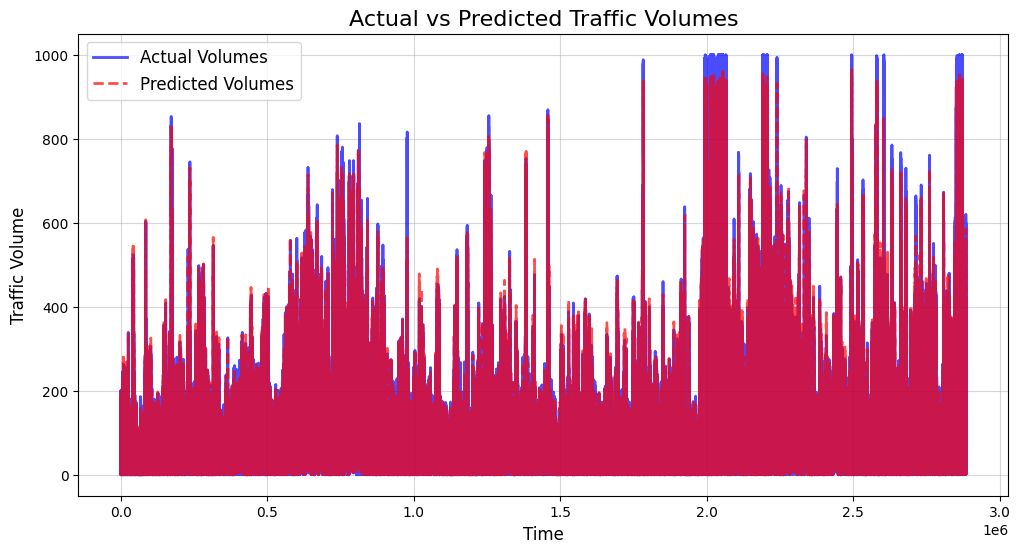

In [25]:
model = load_model('models/v-18.keras'); evaluate_model(model, 2017)

Loading data for year 2018
Preprocessing data...
Extracting features...
Creating sequences...
Test set 2018: 1989158 sequences, each sequence of shape (97, 1)
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
|  Year  | Mean Absolute Error | Mean Absolute Percentage Error | Root Mean Squared Error | Median Absolute Error |      R2 Score      |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
| 2018.0 | 12.194906688497683  |       0.4617603544188997       |    24.20810620608437    |          6.0          | 0.9632586258722716 |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+


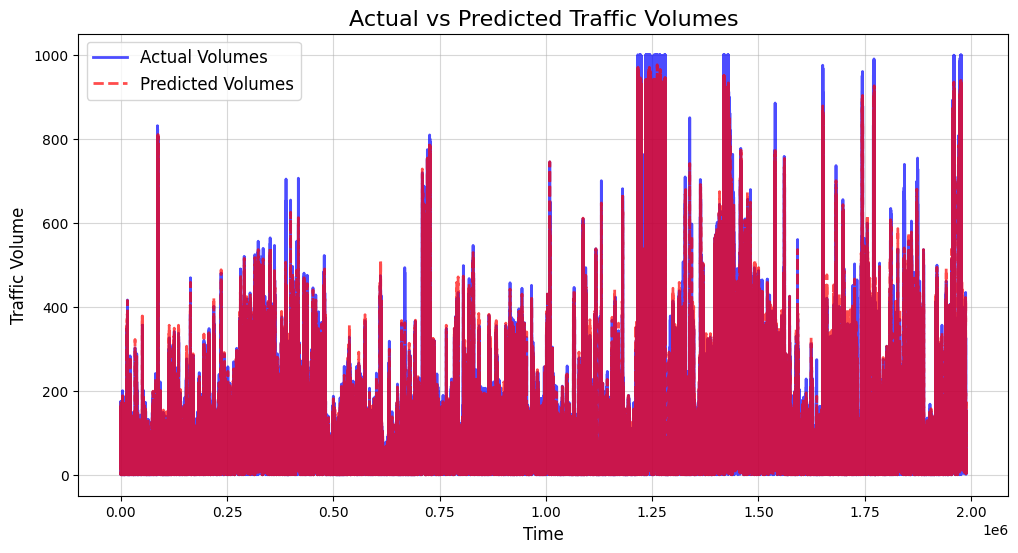

In [26]:
model = load_model('models/v-18.keras'); evaluate_model(model, 2018)

Loading data for year 2019
Preprocessing data...
Extracting features...
Creating sequences...
Test set 2019: 2317291 sequences, each sequence of shape (97, 1)
2262/2262 ━━━━━━━━━━━━━━━━━━━━ 84s 37ms/step
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
|  Year  | Mean Absolute Error | Mean Absolute Percentage Error | Root Mean Squared Error | Median Absolute Error |      R2 Score      |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
| 2019.0 | 12.250581533902519  |      0.30119369192816775       |   22.015199710065456    |          7.0          | 0.9693115690832854 |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+


/home/andystmc/working/wsl-python/wslpy-tensorflow/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


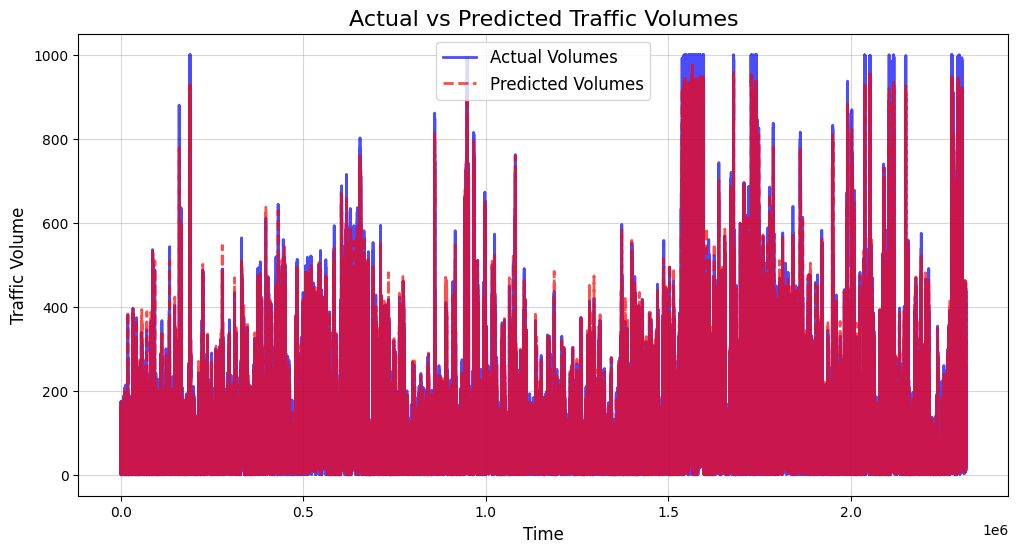

In [27]:
model = load_model('models/v-18.keras'); evaluate_model(model, 2019)

Loading data for year 2020
Preprocessing data...
Extracting features...
Creating sequences...
Test set 2020: 436014 sequences, each sequence of shape (97, 1)
425/425 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
|  Year  | Mean Absolute Error | Mean Absolute Percentage Error | Root Mean Squared Error | Median Absolute Error |      R2 Score      |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+
| 2020.0 | 11.318561580882353  |       0.2764116458717406       |   20.330844205367892    |          6.0          | 0.9737592969376222 |
+--------+---------------------+--------------------------------+-------------------------+-----------------------+--------------------+


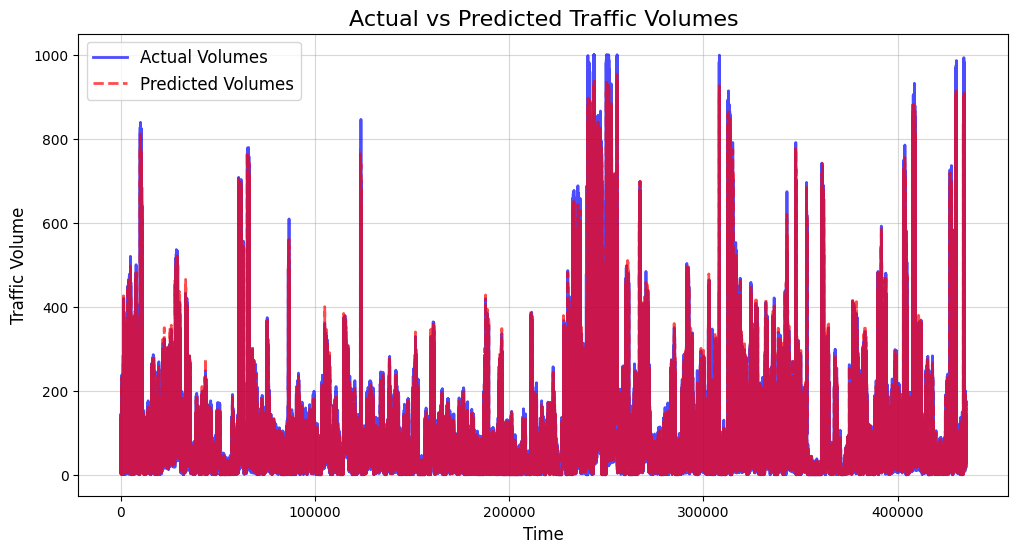

In [28]:
model = load_model('models/v-18.keras'); evaluate_model(model, 2020)